In [124]:
import numpy as np
import matplotlib.pyplot as plt

from numba import njit
from numba.types import intc, CPointer, float64
from numba import cfunc, carray, jit
from scipy import LowLevelCallable
import pandas as pd

from scipy.integrate import quad
from scipy import interpolate
from scipy.integrate import quad
from TO_sim.Get_2ndR_NORM import get_r_rp,Make_R_function
from parfor import parfor
from tqdm.notebook import tqdm

In [3]:
def jit_integrand_function(integrand_function):
    jitted_function = jit(integrand_function, nopython=True)
    @cfunc(float64(intc, CPointer(float64)))
    def wrapped(n, xx):
        values = carray(xx, n)
        return jitted_function(values[0], values[1])
    return LowLevelCallable(wrapped.ctypes)

def jit_integrand_function2(integrand_function):
    jitted_function = jit(integrand_function, nopython=True)
    
    @cfunc(float64(intc, CPointer(float64)))
    def wrapped(n, xx):
        if n < 5:
            raise ValueError("Not enough parameters passed to function.")
        values = carray(xx, n)  # 전달된 모든 파라미터를 포함하는 배열
        return jitted_function(values[0], values[1], values[2], values[3],values[4])
    
    return LowLevelCallable(wrapped.ctypes)


def jit_integrand_function3(integrand_function):
    jitted_function = jit(integrand_function, nopython=True)
    
    @cfunc(float64(intc, CPointer(float64)))
    def wrapped(n, xx):
        if n < 5:
            raise ValueError("Not enough parameters passed to function.")
        values = carray(xx, n)  # 전달된 모든 파라미터를 포함하는 배열
        return jitted_function(values[0], values[1], values[2], values[3],values[4])
    
    return LowLevelCallable(wrapped.ctypes)



@njit
def g(x, mean, std):
    return (1 / (np.sqrt(2 * np.pi) * std)) * np.exp(-0.5 * ((x - mean) / std) ** 2)

@njit
def g_sec(x,Or,Om):
    std = 1
    mean = -Or
    g = (1 / (np.sqrt(2 * np.pi) * std)) * np.exp(-0.5 * ((x - mean) / std) ** 2)
    dO = abs(Or-Om)
    return np.where(x<-dO,1e-6,g)

@jit_integrand_function2
def integrand_Rl(x, X,O_O,O_p,m):
    return g(x,O_O,O_p)*np.sqrt(1-(x/X)**2)

@jit_integrand_function2
def integrand_Rd(x, X,O_O,O_p,m):
    if m == 0:
        return 0
    else:
        return X/(2*(m*x**2+1/m))*g(x,O_O,O_p)

@jit_integrand_function2
def integrand_Rl2(x, X,O_pm,shift_O,m):
    return g_sec(x,O_pm+shift_O,O_pm)*np.sqrt(1-(x/X)**2)

@jit_integrand_function2
def integrand_Rd2(x, X,O_pm,shift_O,m):
    return X/(2*(m*(x+O_pm+shift_O)**2+1/m))*g_sec(x,O_pm+shift_O,O_pm)
    # return 1/(2*(m*(x)**2+1/m))*g_sec(x,O_pm+shift_O,O_pm)


@jit_integrand_function2
def integrand_Rl3(x, X,O_pm,shift_O,m):
    return g(x,0,1)*np.sqrt(1-((x-O_pm-shift_O)/X)**2)


@jit_integrand_function2
def integrand_Rd3(x, X,O_pm,shift_O,m):
    return X/(2*(m*(x-O_pm-shift_O)**2+1/m))*g(x,0,1)

In [4]:
def get_r_Fun(m,Back=False,O_O=20,Inverse=True):
    Xs1 = np.logspace(-15,-3,2000)
    Xs = np.r_[Xs1,np.linspace(1e-3,60,10001)]
    R_0 = np.zeros(len(Xs))
    R_Dh = np.zeros(len(Xs))
    OPS = np.zeros(len(Xs))
    F = {}
    for i,X in enumerate(Xs):
        a = 1/np.sqrt(X*m)
        b = 4/np.pi * a - 0.3056*a**3
        b = np.where(np.where(a>1.193,1,b)>=1,1,b)
        if Back:
            omega_p = min(X,O_O)
        else:
            omega_p = b*X
        OPS[i] = omega_p
        R_0[i],err = quad(integrand_Rl, -omega_p,omega_p,args=(X,0,1,m),limit=200)
        R_Dh[i],err = quad(integrand_Rd,omega_p,np.inf,args=(X,0,1,m),limit=200)
    R_D = -2*R_Dh
    R = R_0 + R_D
    KK = 1/(R/Xs)
    K_min_idx = np.argmin(KK)
    K_d = KK[:K_min_idx]
    K_u = KK[K_min_idx:]
    R_d = R[:K_min_idx]
    R_u = R[K_min_idx:]
    RD_d = R_D[:K_min_idx]
    RD_u = R_D[K_min_idx:]
    R0_d = R_0[:K_min_idx]
    R0_u = R_0[K_min_idx:]
    OPS_d = OPS[:K_min_idx]
    OPS_u = OPS[K_min_idx:]
    F['u'] = {}
    F['u']['R'] = interpolate.interp1d(K_u,R_u,bounds_error=False)
    F['u']['R0'] = interpolate.interp1d(K_u,R0_u,bounds_error=False)
    F['u']['RD'] = interpolate.interp1d(K_u,RD_u,bounds_error=False)
    F['u']['OPS'] = interpolate.interp1d(K_u,OPS_u,bounds_error=False)
    F['d'] = {}
    F['d']['R'] = interpolate.interp1d(K_d,R_d,bounds_error=False)
    F['d']['R0'] = interpolate.interp1d(K_d,R0_d,bounds_error=False)
    F['d']['RD'] = interpolate.interp1d(K_d,RD_d,bounds_error=False)
    F['d']['OPS'] = interpolate.interp1d(K_d,OPS_d,bounds_error=False)
    F['Kc'] = KK[0]
    if Inverse:
        F['I'] = {}
        F['I']['RK'] = interpolate.interp1d(R_u,K_u,bounds_error=False)
        F['I']['ROPS'] = interpolate.interp1d(R_u,OPS_u,bounds_error=False)
    return F

In [5]:
F = get_r_Fun(5)

In [6]:
%timeit get_r_Fun(5)

184 ms ± 6.11 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


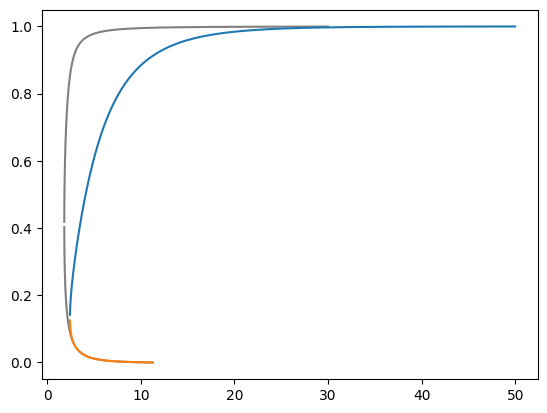

In [1540]:

OPS = F['I']['ROPS'](1)
Kb = F['I']['RK'](1)
Kb
Ksb = np.arange(0,30,0.001)
F_b = get_r_Fun(5,Back=True,O_O=40)
plt.plot(Ksb,F_b['u']['R'](Ksb),color='gray')
plt.plot(Ksb,F_b['d']['R'](Ksb),color='gray')

plt.plot(Ks,F['u']['R'](Ks))
plt.plot(Ks,F['d']['R'](Ks))

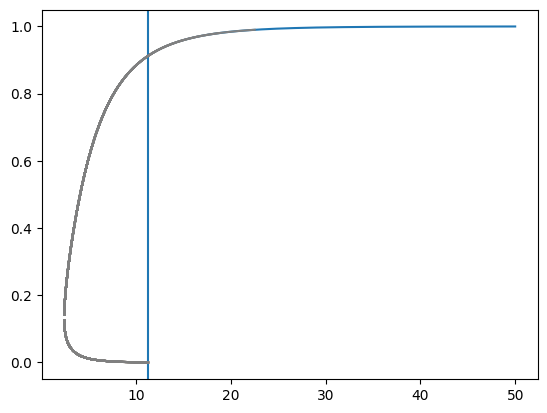

In [1500]:
Ks = np.arange(0,50,0.01)
plt.plot(Ks,F['u']['R'](Ks))
plt.plot(Ks,F['d']['R'](Ks))
plt.axvline(F['Kc'])
r = np.linspace(0,1,100)
for i in r:
    OPS = F['I']['ROPS'](i)
    Kb = F['I']['RK'](i)
    if ~np.isnan(Kb):
        Ksb = np.arange(0,Kb,0.01)
        F_b = get_r_Fun(5,Back=True,O_O=OPS)
        plt.plot(Ksb,F['u']['R'](Ksb),color='gray')
        plt.plot(Ksb,F['d']['R'](Ksb),color='gray')

In [107]:
K = 10
m = 3.9
# rs = np.linspace(0,1,10000)[1:]
Xs1 = np.logspace(-15,-3,2000)
Xs = np.r_[Xs1,np.linspace(1e-3,60,10001)]

R_ls = []
R_drs = []


for X in Xs:
    a = 1/np.sqrt(X*m)
    b = 4/np.pi * a - 0.3056*a**3
    b = np.where(np.where(a>1.193,1,b)>=1,1,b)

    omega_p = b*X
    R_l,err = quad(integrand_Rl, -omega_p,omega_p,args=(X,0,1,m),limit=200)
    R_dr,err = quad(integrand_Rd,omega_p,np.inf,args=(X,0,1,m),limit=200)
    R_ls.append(R_l)
    R_drs.append(R_dr)


R0 = np.array(R_ls)
RD = 2*np.array(R_drs)
R = R0 -RD
KK = 1/(R/Xs)
K_min_arg = np.argmin(KK)

K_d = KK[:K_min_arg]
K_u = KK[K_min_arg:]
r_d = Xs[:K_min_arg]/K_d
r_u = Xs[K_min_arg:]/K_u
R_0d = R0[:K_min_arg]
R_0u = R0[K_min_arg:]
R_dd = -RD[:K_min_arg]
R_du = -RD[K_min_arg:]

R_u = R_0u + R_du
R_d = R_0d + R_dd
K_start = KK[K_min_arg]
Xsu = Xs[K_min_arg:]
Xsd = Xs[:K_min_arg]

a = 1/np.sqrt(Xsu*m)
b = 4/np.pi * a - 0.3056*a**3
b = np.where(np.where(a>1.193,1,b)>=1,1,b)
OPS = b*Xsu


a = 1/np.sqrt(Xsd*m)
b = 4/np.pi * a - 0.3056*a**3
b = np.where(np.where(a>1.193,1,b)>=1,1,b)
OPSd = b*Xsd


In [1447]:
F_ru = interpolate.interp1d(K_u,r_u,bounds_error=False)
F_r0u = interpolate.interp1d(K_u,R_0u,bounds_error=False)
F_rK = interpolate.interp1d(r_u,K_u,bounds_error=False)
F_OPS = interpolate.interp1d(K_u,OPS,bounds_error=False)
r_OPS = interpolate.interp1d(r_u,OPS,bounds_error=False)
F_rd = interpolate.interp1d(K_d,r_d,bounds_error=False)

In [1448]:
Ks_ = np.linspace(0,10,10000)

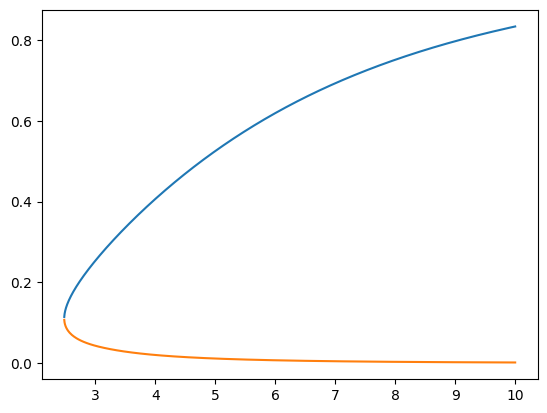

In [1449]:
plt.plot(Ks_,F_ru(Ks_))
plt.plot(Ks_,F_rd(Ks_))

In [1450]:
# Xs1 = np.logspace(-15,-3,1000)
# Xs = np.r_[Xs1,np.linspace(1e-3,50,2001)]

R_ls = []
R_drs = []


for X in Xs:
    omega_p = X
    R_l,err = quad(integrand_Rl, -omega_p,omega_p,args=(X,0,1,m),limit=200)
    R_dr,err = quad(integrand_Rd,omega_p,np.inf,args=(X,0,1,m),limit=200)
    R_ls.append(R_l)
    R_drs.append(R_dr)


R10 = np.array(R_ls)
R1D = 2*np.array(R_drs)
R1 = R10 -R1D
KK1 = 1/(R1/Xs)
K_min_arg = np.argmin(KK)

K_d1 = KK1[:K_min_arg]
K_u1 = KK1[K_min_arg:]
r_d1 = Xs[:K_min_arg]/K_d1
r_u1 = Xs[K_min_arg:]/K_u1
R_01d = R10[:K_min_arg]
R_01u = R10[K_min_arg:]
R_d1d = -R1D[:K_min_arg]
R_d1u = -R1D[K_min_arg:]

R_u1 = R_01u + R_d1u
R_d1 = R_01d + R_d1d

Xsu1 = Xs[K_min_arg:]
Xsd1 = Xs[:K_min_arg]

a = 1/np.sqrt(Xsu*m)
b = 4/np.pi * a - 0.3056*a**3
b = np.where(np.where(a>1.193,1,b)>=1,1,b)
OPS1 = Xsu


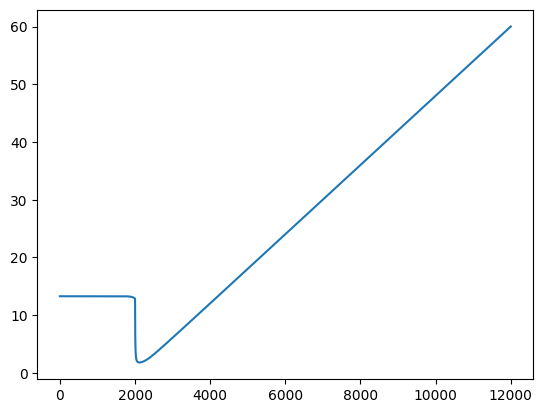

In [1451]:
plt.plot(KK1)

In [ ]:
# Xs1 = np.logspace(-15,-3,1000)
# Xs = np.r_[Xs1,np.linspace(1e-3,50,2001)]


def get_r0_K(Xs,O_O):
    R_ls = []
    R_drs = []
    OPS1 = []
    for X in Xs:
        omega_p = min(X,O_O)
        OPS1.append(omega_p)
        R_l,err = quad(integrand_Rl, -omega_p,omega_p,args=(X,0,1,m),limit=200)
        R_dr,err = quad(integrand_Rd,omega_p,np.inf,args=(X,0,1,m),limit=200)
        R_ls.append(R_l)
        R_drs.append(R_dr)
    R10 = np.array(R_ls)
    R1D = 2*np.array(R_drs)
    R1 = R10 -R1D
    KK1 = 1/(R1/Xs)
    OPS1 = np.array(OPS1)
    return KK1,R1,R10,R1D,OPS1

In [1519]:
%timeit get_r0_K(Xs,0.6)

145 ms ± 1.61 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


(0.0, 1.0)

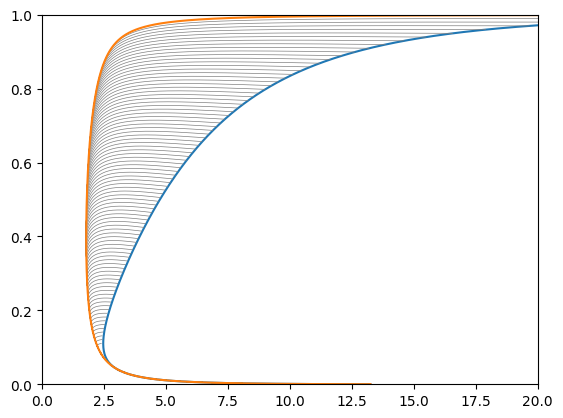

In [1514]:
plt.plot(KK,Xs/KK)
r =  np.linspace(0,1,100)
for i in r:
    Xsd = Xs[:K_min_arg]
    K_i = F_rK(i)
    try:
        K_idx, = np.where(K_u<K_i)
        Xsu = Xs[K_min_arg:][:K_idx[-1]]
        Xs_N = np.r_[Xsd,Xsu]
        KKN,RN,R10,R1D = get_r0_K(Xs_N,r_OPS(i))
        plt.plot(KKN,RN,color='gray',alpha=1,lw=0.5)
    except: pass
plt.plot(KK1,R1)
plt.xlim(0,20)
plt.ylim(0,1)

Text(0, 0.5, '$F(X)=r$')

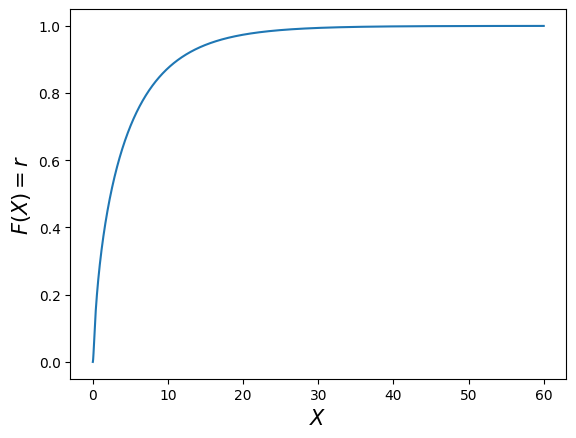

In [1454]:
plt.plot(Xs,R0-RD)
plt.xlabel(r'$X$',fontsize=15)
plt.ylabel(r'$F(X)=r$',fontsize=15)

Text(0, 0.5, '$G(X)=K$')

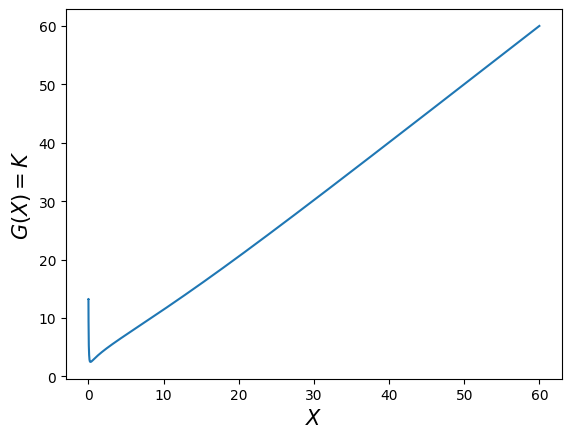

In [1455]:
plt.plot(Xs,KK)
plt.xlabel(r'$X$',fontsize=15)
plt.ylabel(r'$G(X)=K$',fontsize=15)

In [16]:
def set_plot_defaults():
    plt.rc('axes', titlesize=15)     # fontsize of the axes title
    plt.rc('axes', labelsize=15)     # fontsize of the x and y labels
    plt.rc('xtick', labelsize=13)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=13)    # fontsize of the tick labels
    plt.rc('figure', dpi=300)        # dpi of the figure

# Call the function to set the defaults
set_plot_defaults()

Text(0, 0.5, '$F(X)=r$')

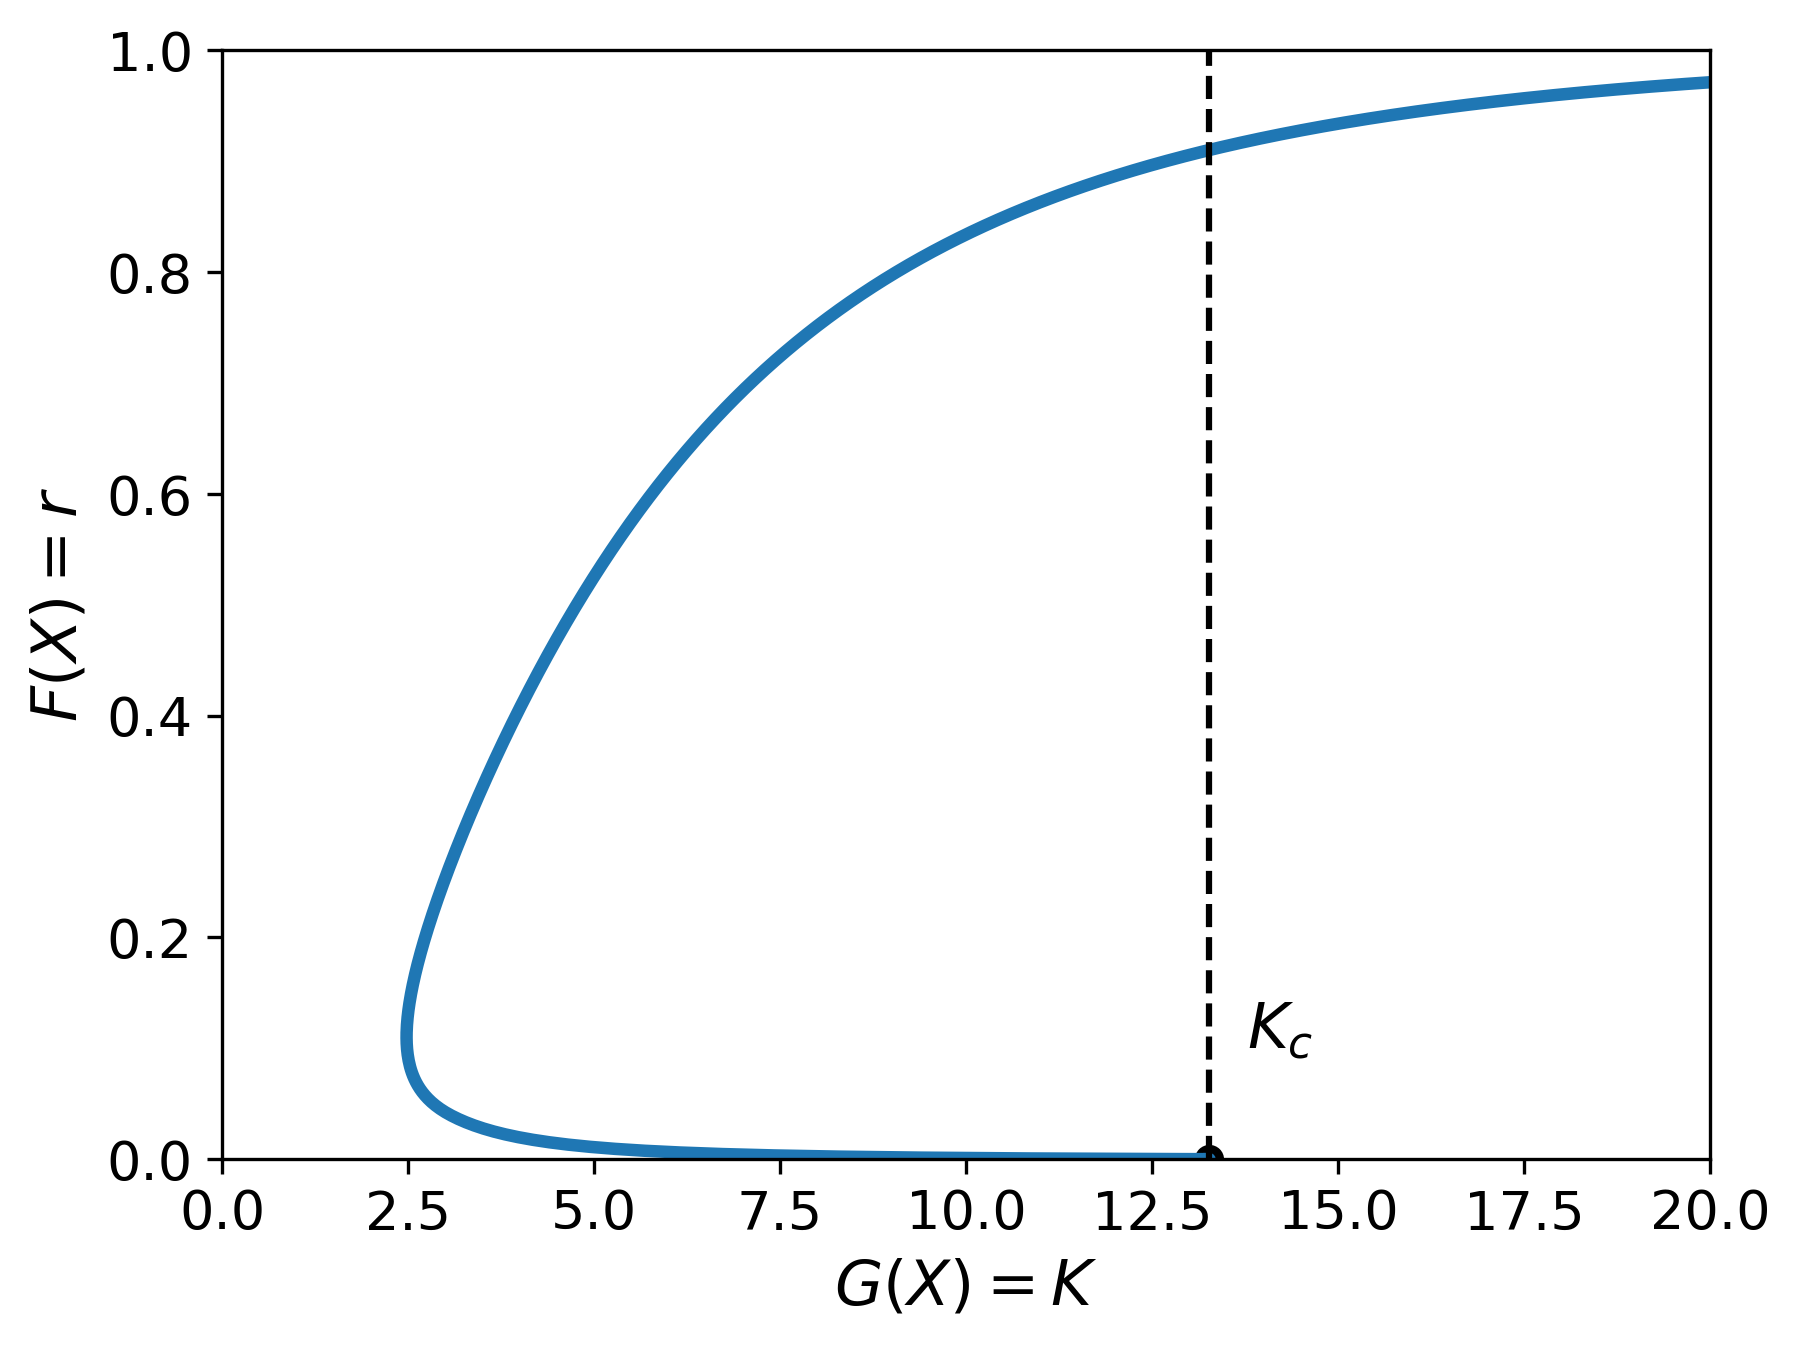

In [17]:
plt.plot(KK,Xs/KK,lw=3)
# plt.plot(KK1,R1)
plt.scatter(KK[0],Xs[0]/KK[0],color='black')
plt.axvline(KK[0],ls='--',color='black')
plt.text(KK[0]+0.5,0.1,r'$K_c$',fontsize=15)
plt.ylim(0,1)
plt.xlim(0,20)
plt.xlabel(r'$G(X)=K$',fontsize=15)
plt.ylabel(r'$F(X)=r$',fontsize=15)


In [1457]:
# RP_u = []
# RP_d = []

# RP0_u = []
# RP0_d = []
# Kp = []

# def get_rp(X,K,r0,OP):
#     rs1 = np.logspace(-6,-2,100)
#     rps = np.r_[rs1,np.linspace(1e-2,(1-r0)/2,200)] 
#     RP_ls = np.nan*rps
#     RP_ds = np.nan*rps

#     for i,rp in enumerate(rps):
#         a = 1/np.sqrt(K*rp*m)
#         b = 4/np.pi * a - 0.3056*a**3
#         b = np.where(np.where(a>1.193,1,b)>=1,1,b)
#         OPs = b*K*rp

#         delta_P = m*K**2*r0*rp/(2*(m**2*OP**2+1)) - K**2*rp**2/(4*OP*(4*m**2*OP**2+1))
#         RP_ls[i],err = quad(integrand_Rl2, -delta_P,+OPs,args=(K*rp,OP,delta_P,m),limit=200)
#         RP_ds[i],err = quad(integrand_Rd2, OPs,np.inf,args=(K*rp,OP,delta_P,m),limit=200)
#     RP = (RP_ls-RP_ds)
#     x, = np.where((RP-rps)>=0)
#     try:
#         rp_d = rps[x[0]]
#         rp_u = rps[x[-1]]
#         rp0_d = RP_ls[x[0]]
#         rp0_u = RP_ls[x[-1]]
#         return K,rp_d,rp_u,rp0_d,rp0_u
#     except:
#         return K,np.nan,np.nan,np.nan,np.nan
    
# get_rp = np.vectorize(get_rp)





# def get_rp1(X,K,r0,OP):
#     rs1 = np.logspace(-6,-2,100)
#     rps = np.r_[rs1,np.linspace(1e-2,(1-r0)/2,200)] 
#     RP_ls = np.nan*rps
#     RP_ds = np.nan*rps

#     for i,rp in enumerate(rps):
#         OPs = K*rp

#         delta_P = m*K**2*r0*rp/(2*(m**2*OP**2+1)) - K**2*rp**2/(4*OP*(4*m**2*OP**2+1))
#         RP_ls[i],err = quad(integrand_Rl2, -delta_P,+OPs,args=(K*rp,OP,delta_P,m),limit=200)
#         RP_ds[i],err = quad(integrand_Rd2, OPs,np.inf,args=(K*rp,OP,delta_P,m),limit=200)
#     RP_ds *= K*rps 
#     RP = (RP_ls-RP_ds)
#     x, = np.where((RP-rps)>=0)
#     try:
#         rp_d = rps[x[0]]
#         rp_u = rps[x[-1]]
#         rp0_d = RP_ls[x[0]]
#         rp0_u = RP_ls[x[-1]]
#         return K,rp_d,rp_u,rp0_d,rp0_u
#     except:
#         return K,np.nan,np.nan,np.nan,np.nan
    
# get_rp1 = np.vectorize(get_rp1)

In [231]:


def get_rp(K,r0,OP,MAX=False):
    rs1 = np.logspace(-6,-3,200)
    rps = np.r_[rs1,np.linspace(1e-3,(1-r0)/2,1000)] 
    RP_ls = np.nan*rps
    RP_ds = np.nan*rps

    for i,rp in enumerate(rps):
        a = 1/np.sqrt(K*rp*m)
        b = 4/np.pi * a - 0.3056*a**3
        b = np.where(np.where(a>1.193,1,b)>=1,1,b)
        if MAX:
            OPs = K*rp
        else:
            OPs = b*K*rp
        delta_P = m*K**2*r0*rp/(2*(m**2*OP**2+1)) - K**2*rp**2/(4*OP*(4*m**2*OP**2+1))
        RP_ls[i],err = quad(integrand_Rl3, OP,OP+delta_P+OPs,args=(K*rp,OP,delta_P,m),limit=200)
        RP_ds[i],err = quad(integrand_Rd, OP+delta_P+OPs,np.inf,args=(K*rp,0,1,m),limit=200)


    RP = (RP_ls-RP_ds)
    x, = np.where((RP-rps)>=0)
    try:
        rp_d = rps[x[0]]
        rp_u = rps[x[-1]]
        rp0_d = RP_ls[x[0]]
        rp0_u = RP_ls[x[-1]]
        return K,rp_d,rp_u,rp0_d,rp0_u
    except:
        return K,np.nan,np.nan,np.nan,np.nan
    
get_rp = np.vectorize(get_rp)

def get_RP():
    Ks,rp_d,rp_u,rp0_d,rp0_u = get_rp(K_urp,R_0u,OPS,MAX=False)




def get_rp2(K,r0,OP,O_2=0):
    rs1 = np.logspace(-6,-2,100)
    rps = np.r_[rs1,np.linspace(1e-2,(1-r0)/2,300)] 
    RP_ls = np.nan*rps
    RP_ds = np.nan*rps

    for i,rp in enumerate(rps):
        a = 1/np.sqrt(K*rp*m)
        b = 4/np.pi * a - 0.3056*a**3
        b = np.where(np.where(a>1.193,1,b)>=1,1,b)
        OPs = max(b*K*rp,O_2)
        delta_P = m*K**2*r0*rp/(2*(m**2*OP**2+1)) - K**2*rp**2/(4*OP*(4*m**2*OP**2+1))
        RP_ls[i],err = quad(integrand_Rl3, OP,OP+delta_P+OPs,args=(K*rp,OP,delta_P,m),limit=200)
        RP_ds[i],err = quad(integrand_Rd, OP+delta_P+OPs,np.inf,args=(K*rp,0,1,m),limit=200)


    RP = (RP_ls-RP_ds)
    x, = np.where((RP-rps)>=0)
    try:
        rp_d = rps[x[0]]
        rp_u = rps[x[-1]]
        rp0_d = RP_ls[x[0]]
        rp0_u = RP_ls[x[-1]]
        return K,rp_d,rp_u,rp0_d,rp0_u
    except:
        return K,np.nan,np.nan,np.nan,np.nan
    
get_rp2 = np.vectorize(get_rp2)


In [1552]:
F = get_r_Fun(m,Back=True)

In [1555]:
Ks = np.arange(0,20,0.1)
R_0u = F['u']['R0'](Ks)
idx = np.isnan(R_0u)
K_urp = Ks[~idx]
R_0u = R_0u[~idx]
OPS = F['u']['OPS'](K_urp)

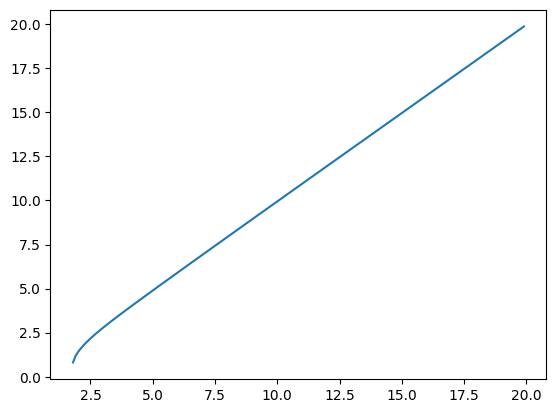

In [1556]:
plt.plot(K_urp,OPS)

In [1557]:
Ks = np.arange(0,20,0.1)
R_0u = F['u']['R0'](Ks)
idx = np.isnan(R_0u)
K_urp = Ks[~idx]
R_0u = R_0u[~idx]
OPS = F['u']['OPS'](K_urp)
Ks,rp_d,rp_u,rp0_d,rp0_u = get_rp(K_urp,R_0u,OPS,MAX=False)
KsM,rpM_d,rpM_u,rpM0_d,rpM0_u = get_rp(K_urp,R_0u,OPS,MAX=True)
# K1,rp_d1,rp_u1,rp0_d1,rp0_u1 = get_rp1(K_u,R_0u,OPS)

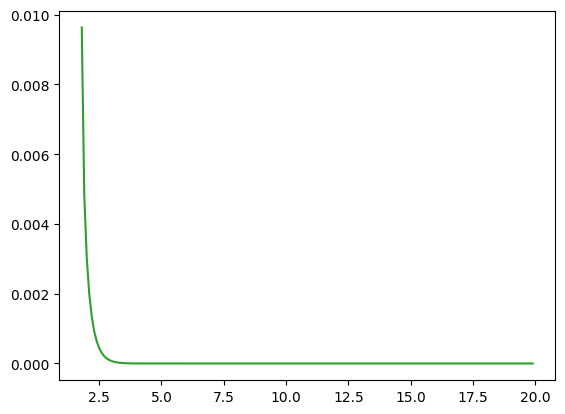

In [1558]:
plt.plot(Ks,rp_u)
plt.plot(Ks,rp_d)
plt.plot(Ks,-F['u']['RD'](Ks)/2)
plt.plot(KsM,rpM_u)
plt.plot(KsM,rpM_d)

In [1475]:
Ks1,rp1_d,rp1_u,_,_ = get_rp(K_u1,R_01u,OPS1,MAX=False)
Ks1M,rp1M_d,rp1M_u,_,_ = get_rp(K_u1,R_01u,OPS1,MAX=True)

KeyboardInterrupt: 

In [ ]:
Ks1M,rp1M_d,rp1M_u,_,_ = get_rp2(K_u1,R_01u,OPS1,O_2=0.5)


/var/folders/z1/v9g3442s1hn29m34fht7zq8h0000gn/T/ipykernel_33840/3263129502.py:48: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  RP_ls[i],err = quad(integrand_Rl3, OP,OP+delta_P+OPs,args=(K*rp,OP,delta_P,m),limit=200)


In [1092]:
KsM,rpM_d,rpM_u,rpM0_d,rpM0_u = get_rp(Xsu,K_u,R_0u,OPS,MAX=True)


In [878]:
K_0 = Ks[~np.isnan(rp_d)][0]
K_1 = Ks[~np.isnan(rp_d)][-1]

In [879]:
K_0,K_1

(3.269315251234632, 5.229188516950889)

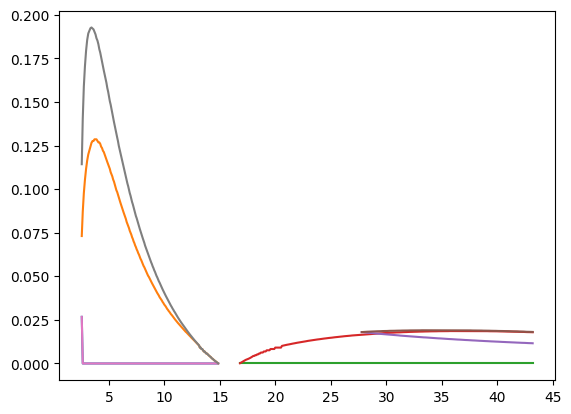

In [1097]:
plt.plot(Ks,rp_d)
plt.plot(Ks,rp_u)

plt.plot(Ks1,rp1_d)
plt.plot(Ks1,rp1_u)
plt.plot(Ks1M,rp1M_d)
plt.plot(Ks1M,rp1M_u)

plt.plot(KsM,rpM_d)
plt.plot(KsM,rpM_u)


In [44]:
RP1_u = []
RP1_d = []
RP01_u = []
RP01_d = []

K1p = []
for X,K,r,r0,rd,OP in zip(Xsu,K_u,R_u,R_0u,R_du,OPS):
    rs1 = np.logspace(-6,-2,100)
    rps = np.r_[rs1,np.linspace(1e-2,(1-r0)/2,200)] 
    omega_pp = X
    RP_ls = np.nan*rps
    RP_ds = np.nan*rps

    for i,rp in enumerate(rps):
        OPs = K*rp

        delta_P = m*K**2*r0*rp/(2*(m**2*OP**2+1)) - K**2*rp**2/(4*OP*(4*m**2*OP**2+1))
        RP_ls[i],err = quad(integrand_Rl3, OP,OP+delta_P+OPs,args=(K*rp,OP,delta_P,m),limit=200)
        RP_ds[i],err = quad(integrand_Rd, OP+delta_P+OPs,np.inf,args=(K*rp,0,1,m),limit=200)
    RP = (RP_ls-RP_ds)
    x, = np.where((RP-rps)>=0)
    try:
        RP1_u.append(rps[x[-1]])
        RP1_d.append(rps[x[0]])
        RP01_u.append(RP_ls[x[-1]])
        RP01_d.append(RP_ls[x[0]])
        K1p.append(K)
    except:break

In [21]:
F = get_r_Fun(m)

In [260]:
K = 5
r0 = float(F['u']['R0'](K))
r = float(F['u']['R'](K))
OP = float(F['u']['OPS'](K))
X = K*r

In [261]:
rs1 = np.logspace(-6,-2,100)
rps = np.r_[rs1,np.linspace(1e-2,(1-r0)/2,200)] 
omega_pp = X
RP_ls = np.nan*rps
RP_ds = np.nan*rps

for i,rp in enumerate(rps):
    OPs = K*rp

    delta_P = m*K**2*r0*rp/(2*(m**2*OP**2+1)) - K**2*rp**2/(4*OP*(4*m**2*OP**2+1))
    RP_ls[i],err = quad(integrand_Rl3, OP,OP+delta_P+OPs,args=(K*rp,OP,delta_P,m),limit=200)
    RP_ds[i],err = quad(integrand_Rd, OP+delta_P+OPs,np.inf,args=(K*rp,0,1,m),limit=200)
RP = (RP_ls-RP_ds)
x, = np.where((RP-rps)>=0)

In [262]:
RP_ls

array([1.37433299e-06, 1.50832834e-06, 1.65538798e-06, 1.81678566e-06,
       1.99391928e-06, 2.18832306e-06, 2.40168079e-06, 2.63584041e-06,
       2.89283005e-06, 3.17487554e-06, 3.48441974e-06, 3.82413546e-06,
       4.19698068e-06, 4.60617719e-06, 5.05526905e-06, 5.54814583e-06,
       6.08907634e-06, 6.68274549e-06, 7.33429496e-06, 8.04936767e-06,
       8.83415662e-06, 9.69545857e-06, 1.06407328e-05, 1.16781571e-05,
       1.28167325e-05, 1.40663115e-05, 1.54377153e-05, 1.69428203e-05,
       1.85946604e-05, 2.04075396e-05, 2.23971566e-05, 2.45807398e-05,
       2.69771968e-05, 2.96072778e-05, 3.24937553e-05, 3.56616112e-05,
       3.91382905e-05, 4.29538837e-05, 4.71414226e-05, 5.17371572e-05,
       5.67808689e-05, 6.23162140e-05, 6.83911014e-05, 7.50581055e-05,
       8.23749209e-05, 9.04048595e-05, 9.92173883e-05, 1.08888764e-04,
       1.19502638e-04, 1.31150810e-04, 1.43934012e-04, 1.57962776e-04,
       1.73358381e-04, 1.90253899e-04, 2.08795338e-04, 2.29142890e-04,
      

Text(0, 0.5, '$J(X,r_+)$')

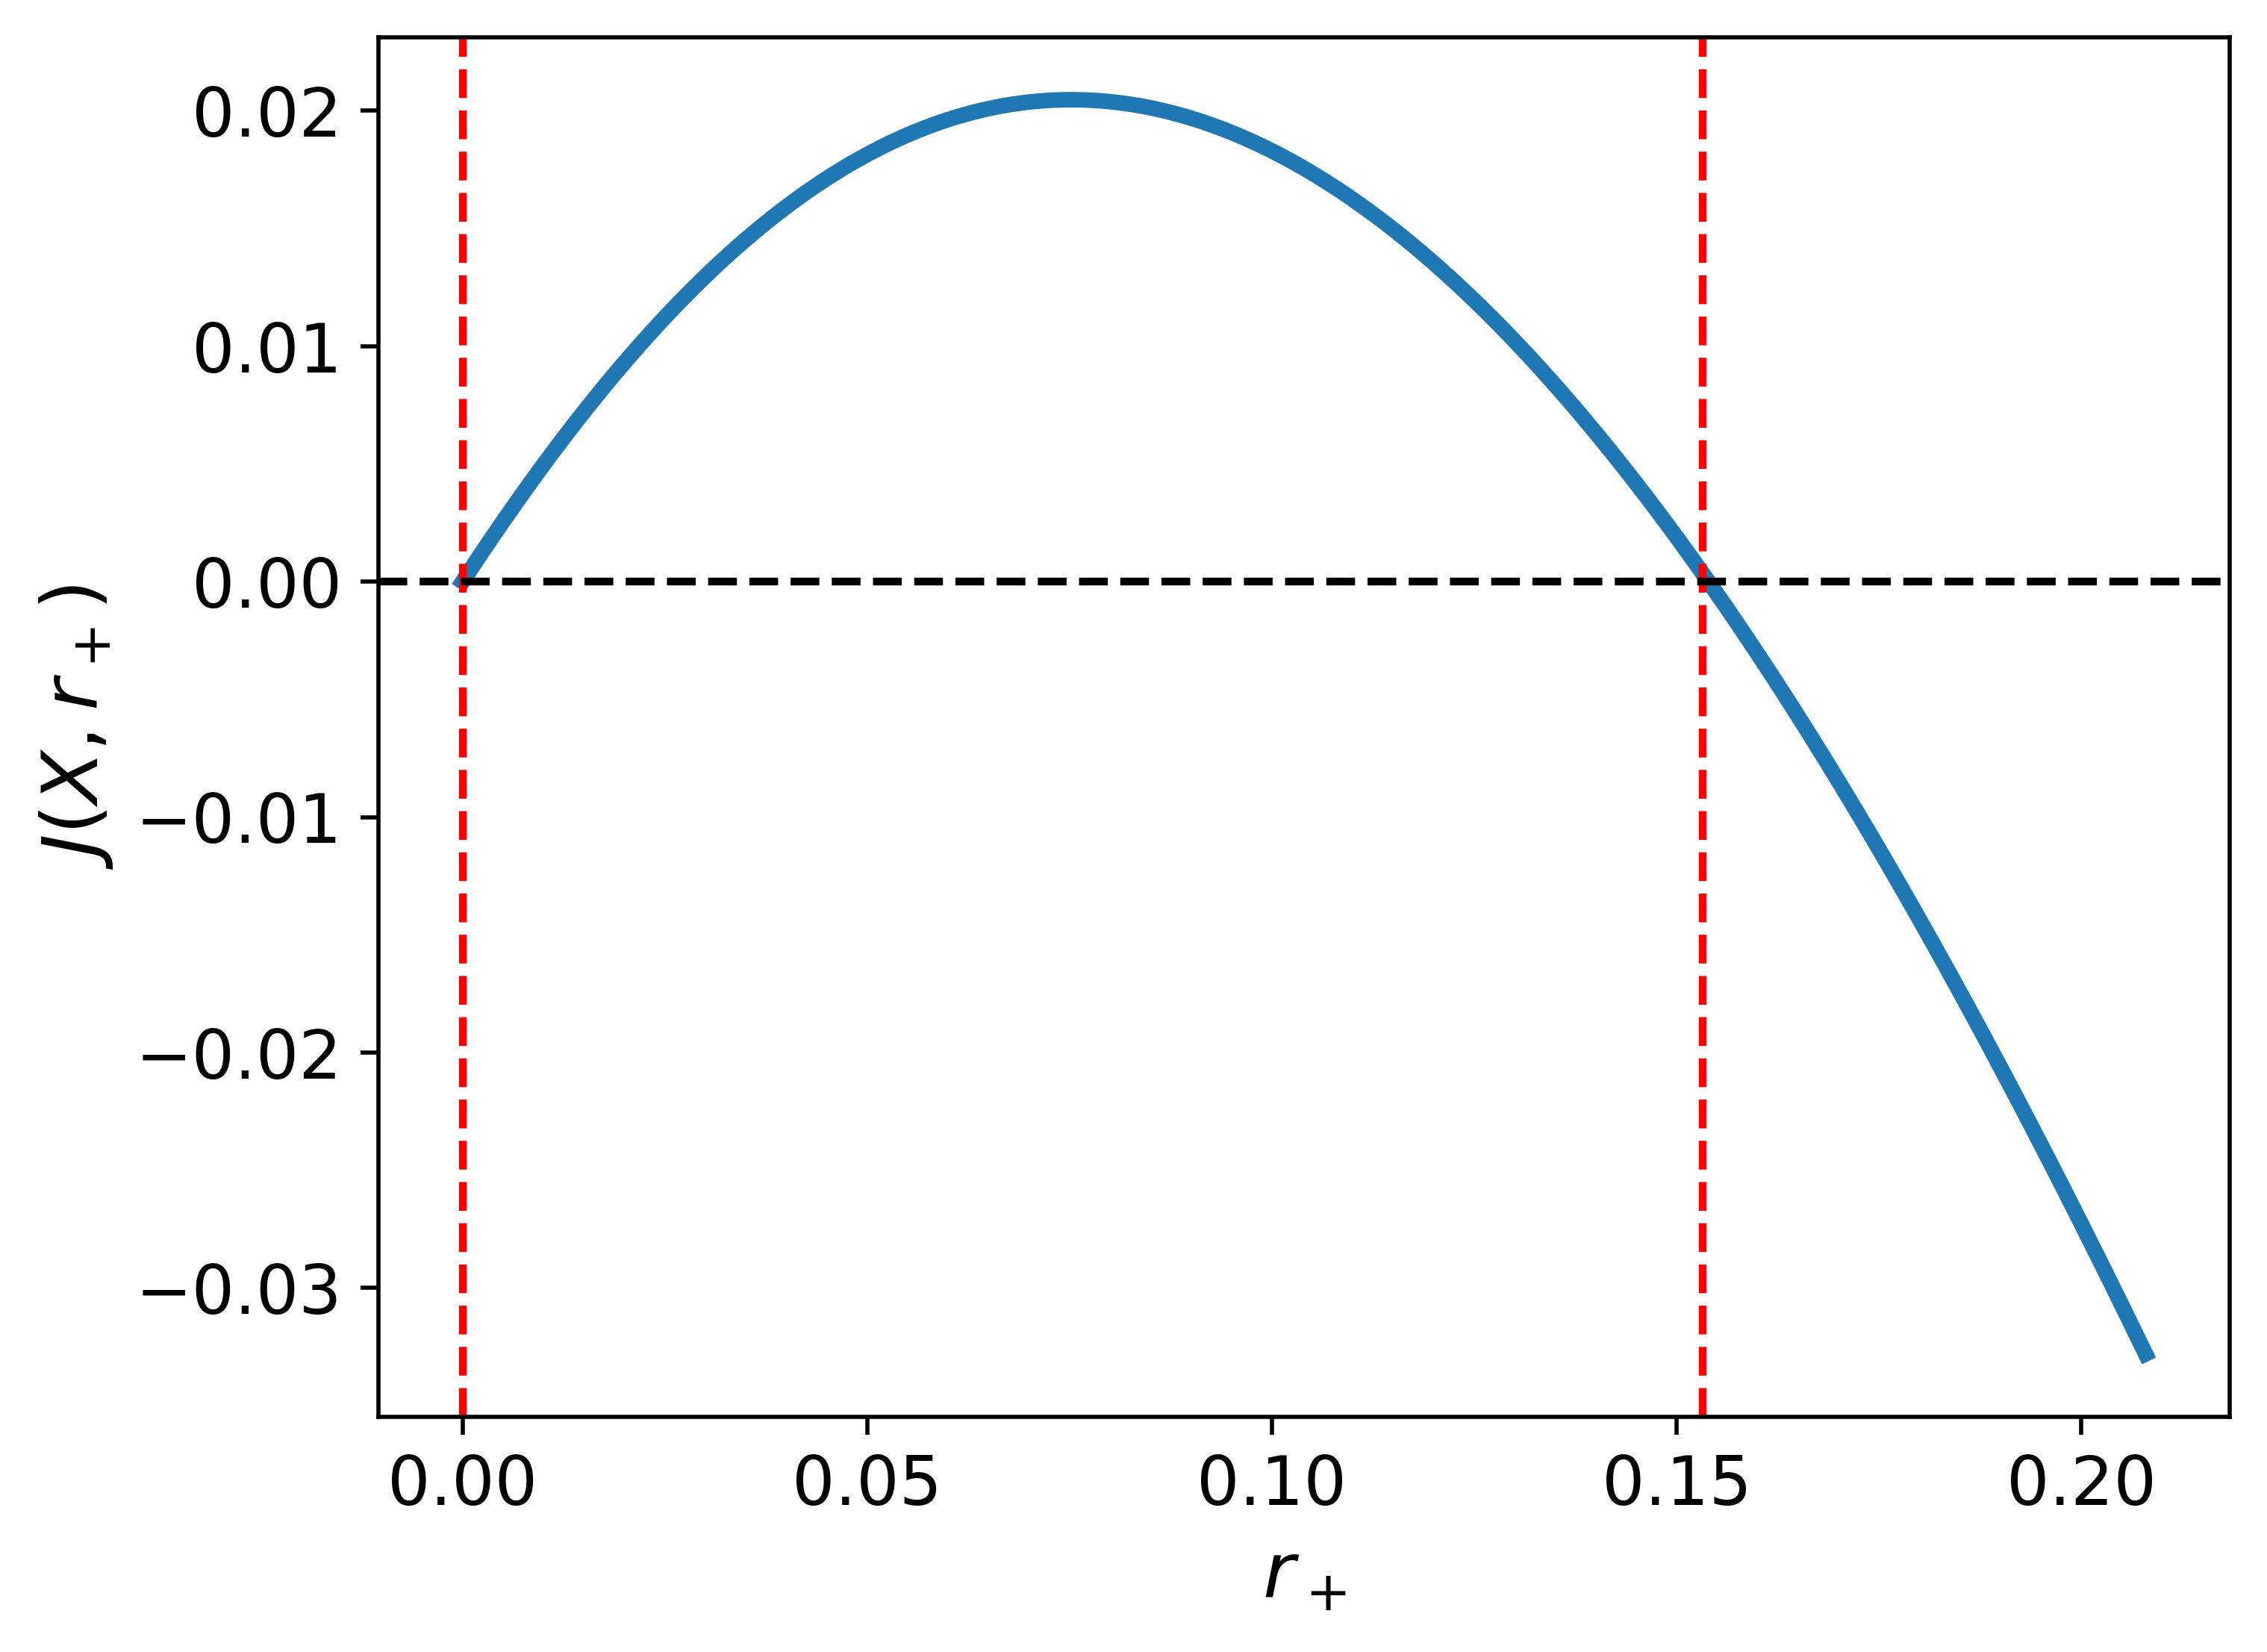

In [89]:
plt.figure(dpi=500)
plt.plot(rps,RP-rps,lw=3)
plt.axvline(rps[x[0]],color='red',ls='--')
plt.axvline(rps[x[-1]],color='red',ls='--')
plt.axhline(0,color='black',ls='--')
# plt.xlim(0,)
plt.xlabel(r'$r_+$',fontsize=15)
plt.ylabel(r'$J(X,r_+)$',fontsize=15)
# plt.title(rf'$X={X:.02f},G(X)={K},m={m}$')

# find Critical m

In [158]:
m = 3.9
ms = np.linspace(3.8,10,621)
# @parfor(ms)
def get_Kritical(m):
# rs = np.linspace(0,1,10000)[1:]
    Xs1 = np.logspace(-15,-3,200)
    Xs = np.r_[Xs1,np.linspace(1e-3,100,6001)]

    R0 = np.nan*np.zeros(len(Xs))
    RDh = np.nan*np.zeros(len(Xs))
    OPS = np.nan*np.zeros(len(Xs))

    for i,X in enumerate(Xs):
        a = 1/np.sqrt(X*m)
        b = 4/np.pi * a - 0.3056*a**3
        b = np.where(np.where(a>1.193,1,b)>=1,1,b)

        omega_p = b*X
        R0[i],err = quad(integrand_Rl, -omega_p,omega_p,args=(X,0,1,m),limit=200)
        RDh[i],err = quad(integrand_Rd,omega_p,np.inf,args=(X,0,1,m),limit=200)
        OPS[i] = omega_p

    RD = 2*RDh
    R = R0 -RD
    KK = Xs/R
    K_min_arg = np.argmin(KK)
    K_u = KK[K_min_arg:]
    r_u = Xs[K_min_arg:]/K_u
    R_0u = R0[K_min_arg:]
    R_du = -RD[K_min_arg:]
    OPSu = OPS[K_min_arg:]

    R_u = R_0u + R_du
    K_start = KK[K_min_arg]
    Xsu = Xs[K_min_arg:]

    RPS = []
    K1p = []
    for X,K,r,r0,rd,OP in zip(Xsu,K_u,R_u,R_0u,R_du,OPSu):
        omega_pp = X
        rp = -rd/2
        a = 1/np.sqrt(K*rp*m)
        b = 4/np.pi * a - 0.3056*a**3
        b = np.where(np.where(a>1.193,1,b)>=1,1,b)
        OPs = b*K*rp

        delta_P = m*K**2*r0*rp/(2*(m**2*OP**2+1)) - K**2*rp**2/(4*OP*(4*m**2*OP**2+1))
        RP_ls,err = quad(integrand_Rl3, OP,OP+delta_P+OPs,args=(K*rp,OP,delta_P,m),limit=200)
        RP_ds,err = quad(integrand_Rd, OP+delta_P+OPs,np.inf,args=(K*rp,0,1,m),limit=200)
        RP = (RP_ls-RP_ds)
        RPS.append(RP)
    x, = np.where(RPS+R_du/2>=0)
    K_sd = np.nan
    K_su = np.nan
    if len(x)>0:
        K_sd = K_u[x[0]]
        K_su = K_u[x[-1]]
    return K_sd,K_su
# get_Kritical = np.vectorize(get_Kritical)

In [162]:
ms1 = np.linspace(3.86,3.87,101)[:-1]

In [163]:
K_sds0 = np.nan * ms1
K_sus0 = np.nan * ms1
for i,m in enumerate(tqdm(ms1)):
    K_sds0[i],K_sus0[i] = get_Kritical(m)

  0%|          | 0/100 [00:00<?, ?it/s]

In [159]:
K_sds = np.nan * ms
K_sus = np.nan * ms
for i,m in enumerate(tqdm(ms)):
    K_sds[i],K_sus[i] = get_Kritical(m)

  0%|          | 0/621 [00:00<?, ?it/s]

In [177]:
ms_ = np.r_[ms1[~np.isnan(K_sds0)],ms[~np.isnan(K_sds)]]
K_sd = np.r_[K_sds0[~np.isnan(K_sds0)],K_sds[~np.isnan(K_sds)]]
K_su = np.r_[K_sus0[~np.isnan(K_sds0)],K_sus[~np.isnan(K_sds)]]

In [180]:
m_c = np.r_[ms_[::-1],ms_]
K_c = np.r_[K_sd[::-1],K_su]

In [196]:
K_ = min(K_sus0[~np.isnan(K_sus0)])
K_

3.9462587748071387

In [199]:
min(m_c)

3.8684000000000003

Text(0, 0.5, '$m^*$')

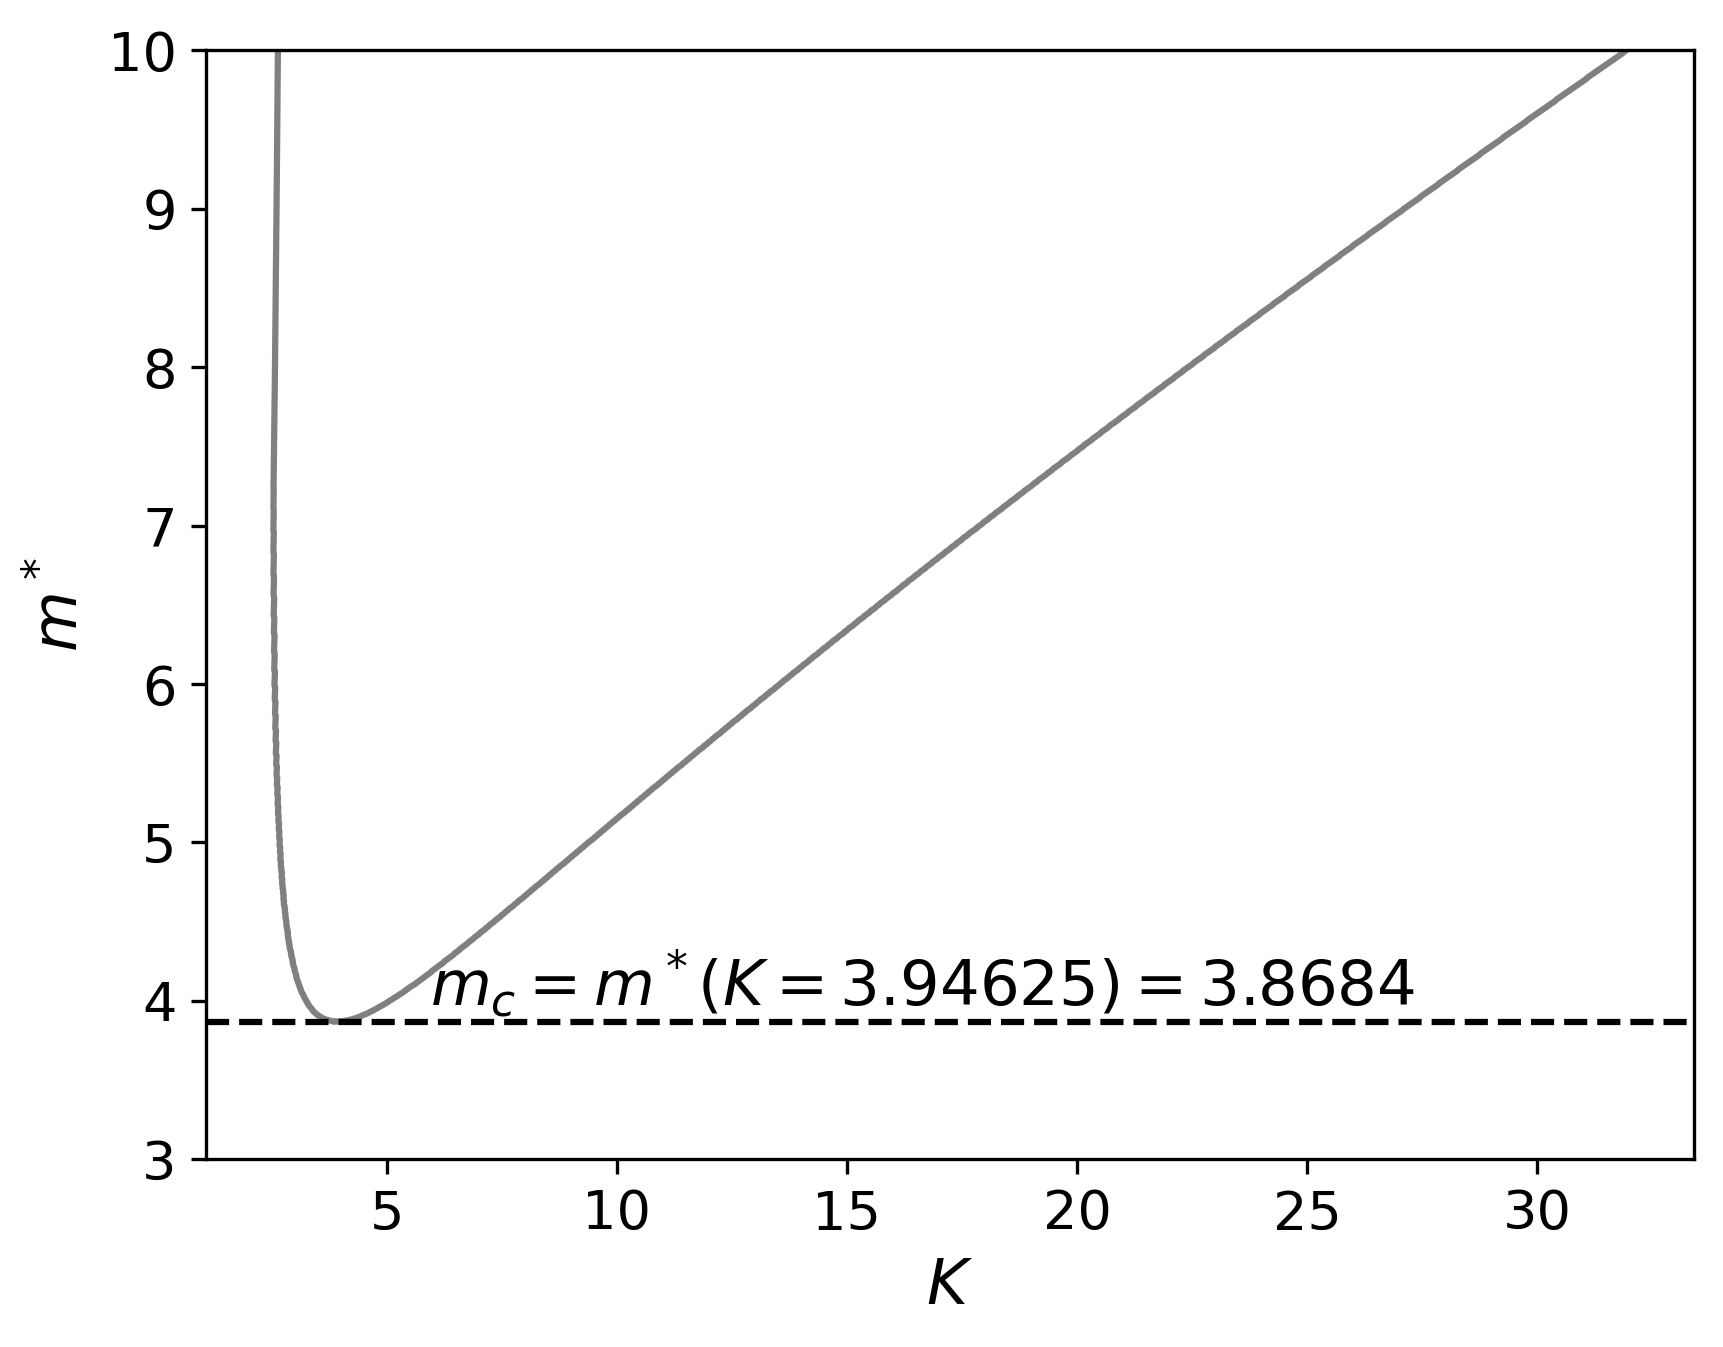

In [207]:
plt.plot(K_c,m_c,color='gray')
plt.ylim(3,10)
plt.axhline(min(m_c),ls='--',color='black')
# plt.scatter(K_,min(m_c),color='red',marker='s')
plt.text(min(K_sus0[~np.isnan(K_sus0)])+2,min(m_c)+0.1,r'$m_c=m^*(K=3.94625)=3.8684$',fontsize=15)
# plt.axvline(min(K_sus0[~np.isnan(K_sus0)]),ls=':',color='black')
plt.xlabel(r'$K$')
plt.ylabel(r'$m^*$')
# plt.xlim(3,10)

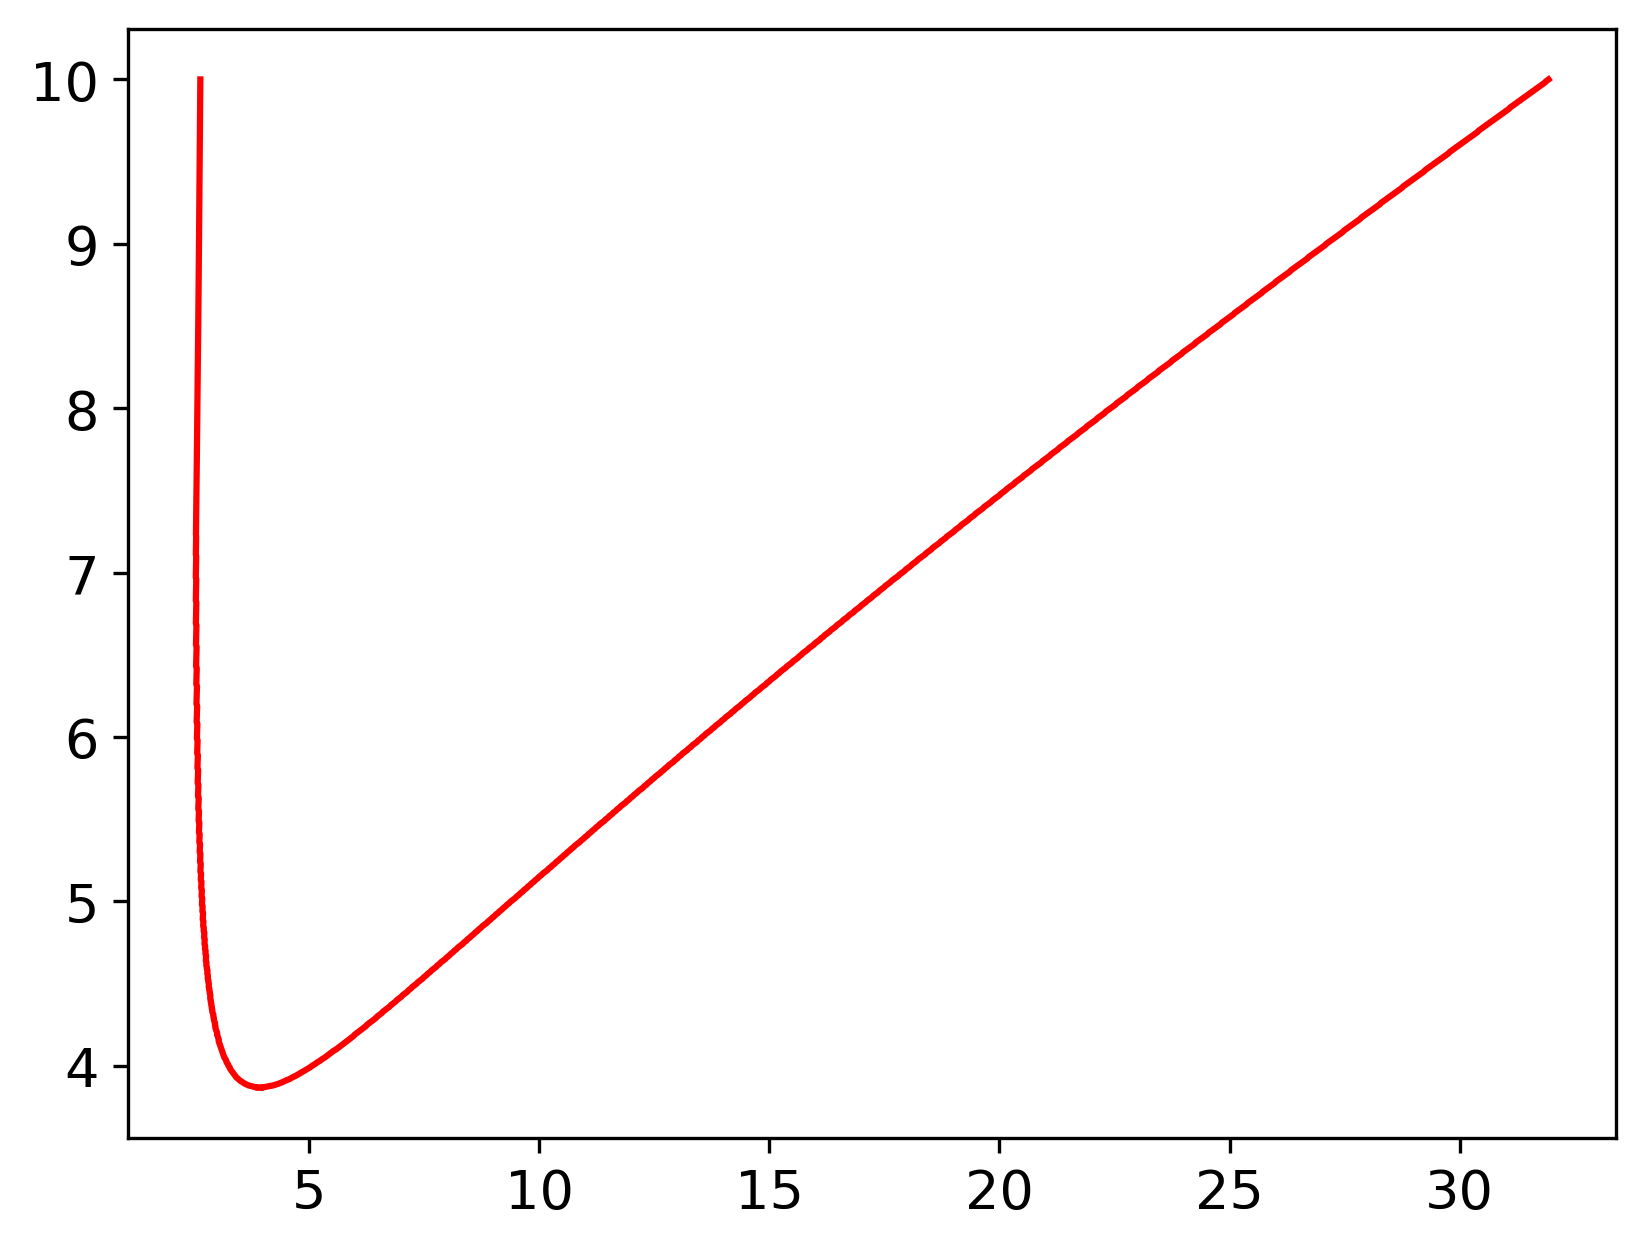

In [179]:
plt.plot(K_sd,ms_,color='red')
plt.plot(K_su,ms_,color='red')

In [164]:
ms1[~np.isnan(K_sds0)]

array([3.8684, 3.8685, 3.8686, 3.8687, 3.8688, 3.8689, 3.869 , 3.8691,
       3.8692, 3.8693, 3.8694, 3.8695, 3.8696, 3.8697, 3.8698, 3.8699])

In [165]:
ms[~np.isnan(K_sds)]

array([ 3.87,  3.88,  3.89,  3.9 ,  3.91,  3.92,  3.93,  3.94,  3.95,
        3.96,  3.97,  3.98,  3.99,  4.  ,  4.01,  4.02,  4.03,  4.04,
        4.05,  4.06,  4.07,  4.08,  4.09,  4.1 ,  4.11,  4.12,  4.13,
        4.14,  4.15,  4.16,  4.17,  4.18,  4.19,  4.2 ,  4.21,  4.22,
        4.23,  4.24,  4.25,  4.26,  4.27,  4.28,  4.29,  4.3 ,  4.31,
        4.32,  4.33,  4.34,  4.35,  4.36,  4.37,  4.38,  4.39,  4.4 ,
        4.41,  4.42,  4.43,  4.44,  4.45,  4.46,  4.47,  4.48,  4.49,
        4.5 ,  4.51,  4.52,  4.53,  4.54,  4.55,  4.56,  4.57,  4.58,
        4.59,  4.6 ,  4.61,  4.62,  4.63,  4.64,  4.65,  4.66,  4.67,
        4.68,  4.69,  4.7 ,  4.71,  4.72,  4.73,  4.74,  4.75,  4.76,
        4.77,  4.78,  4.79,  4.8 ,  4.81,  4.82,  4.83,  4.84,  4.85,
        4.86,  4.87,  4.88,  4.89,  4.9 ,  4.91,  4.92,  4.93,  4.94,
        4.95,  4.96,  4.97,  4.98,  4.99,  5.  ,  5.01,  5.02,  5.03,
        5.04,  5.05,  5.06,  5.07,  5.08,  5.09,  5.1 ,  5.11,  5.12,
        5.13,  5.14,

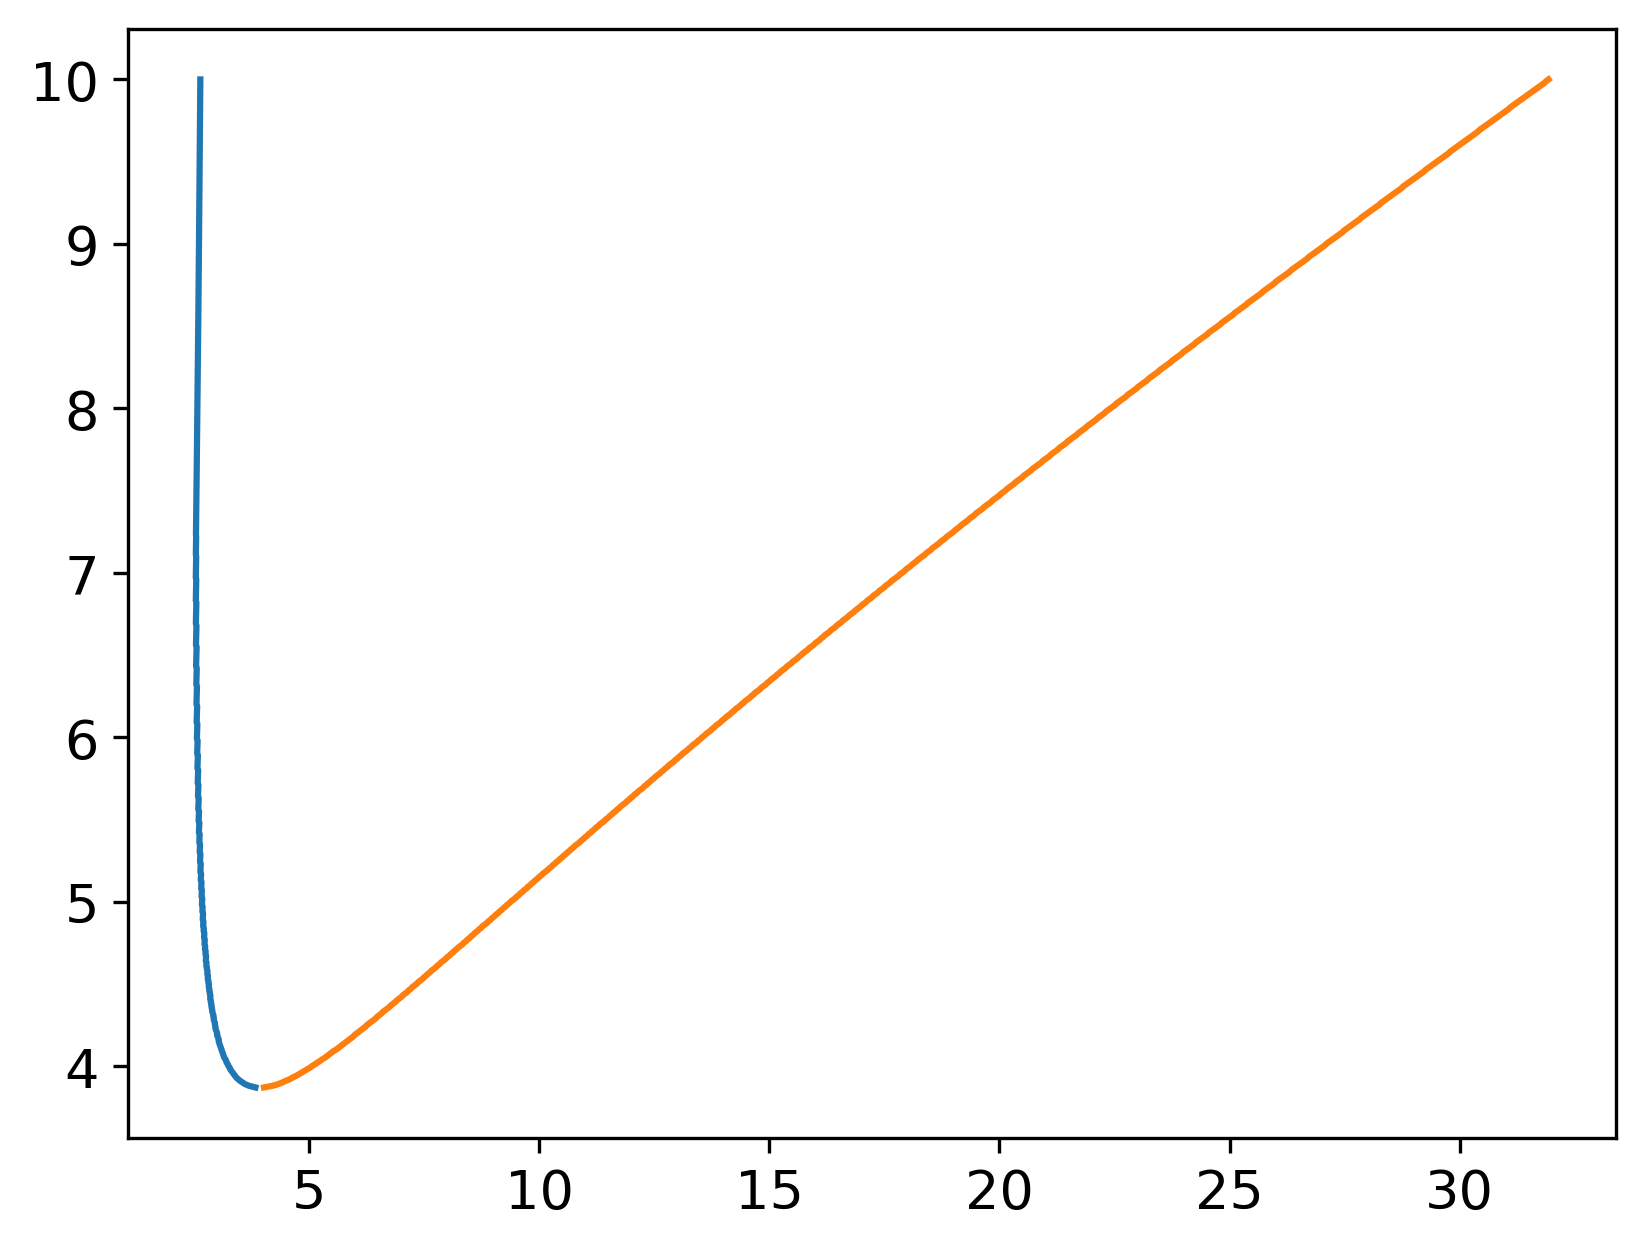

In [160]:
plt.plot(K_sds,ms)
plt.plot(K_sus,ms)

In [111]:
RPSd = []

K1p = []
for X,K,r,r0,rd,OP in zip(Xsd,K_d,R_d,R_0d,R_dd,OPSd):
    omega_pp = X
    rp = -rd/2
    a = 1/np.sqrt(K*rp*m)
    b = 4/np.pi * a - 0.3056*a**3
    b = np.where(np.where(a>1.193,1,b)>=1,1,b)
    OPs = b*K*rp

    delta_P = m*K**2*r0*rp/(2*(m**2*OP**2+1)) - K**2*rp**2/(4*OP*(4*m**2*OP**2+1))
    RP_ls,err = quad(integrand_Rl3, OP,OP+delta_P+OPs,args=(K*rp,OP,delta_P,m),limit=200)
    RP_ds,err = quad(integrand_Rd, OP+delta_P+OPs,np.inf,args=(K*rp,0,1,m),limit=200)
    RP = (RP_ls-RP_ds)
    RPSd.append(RP)

Text(0.5, 1.0, '$m=3.9$')

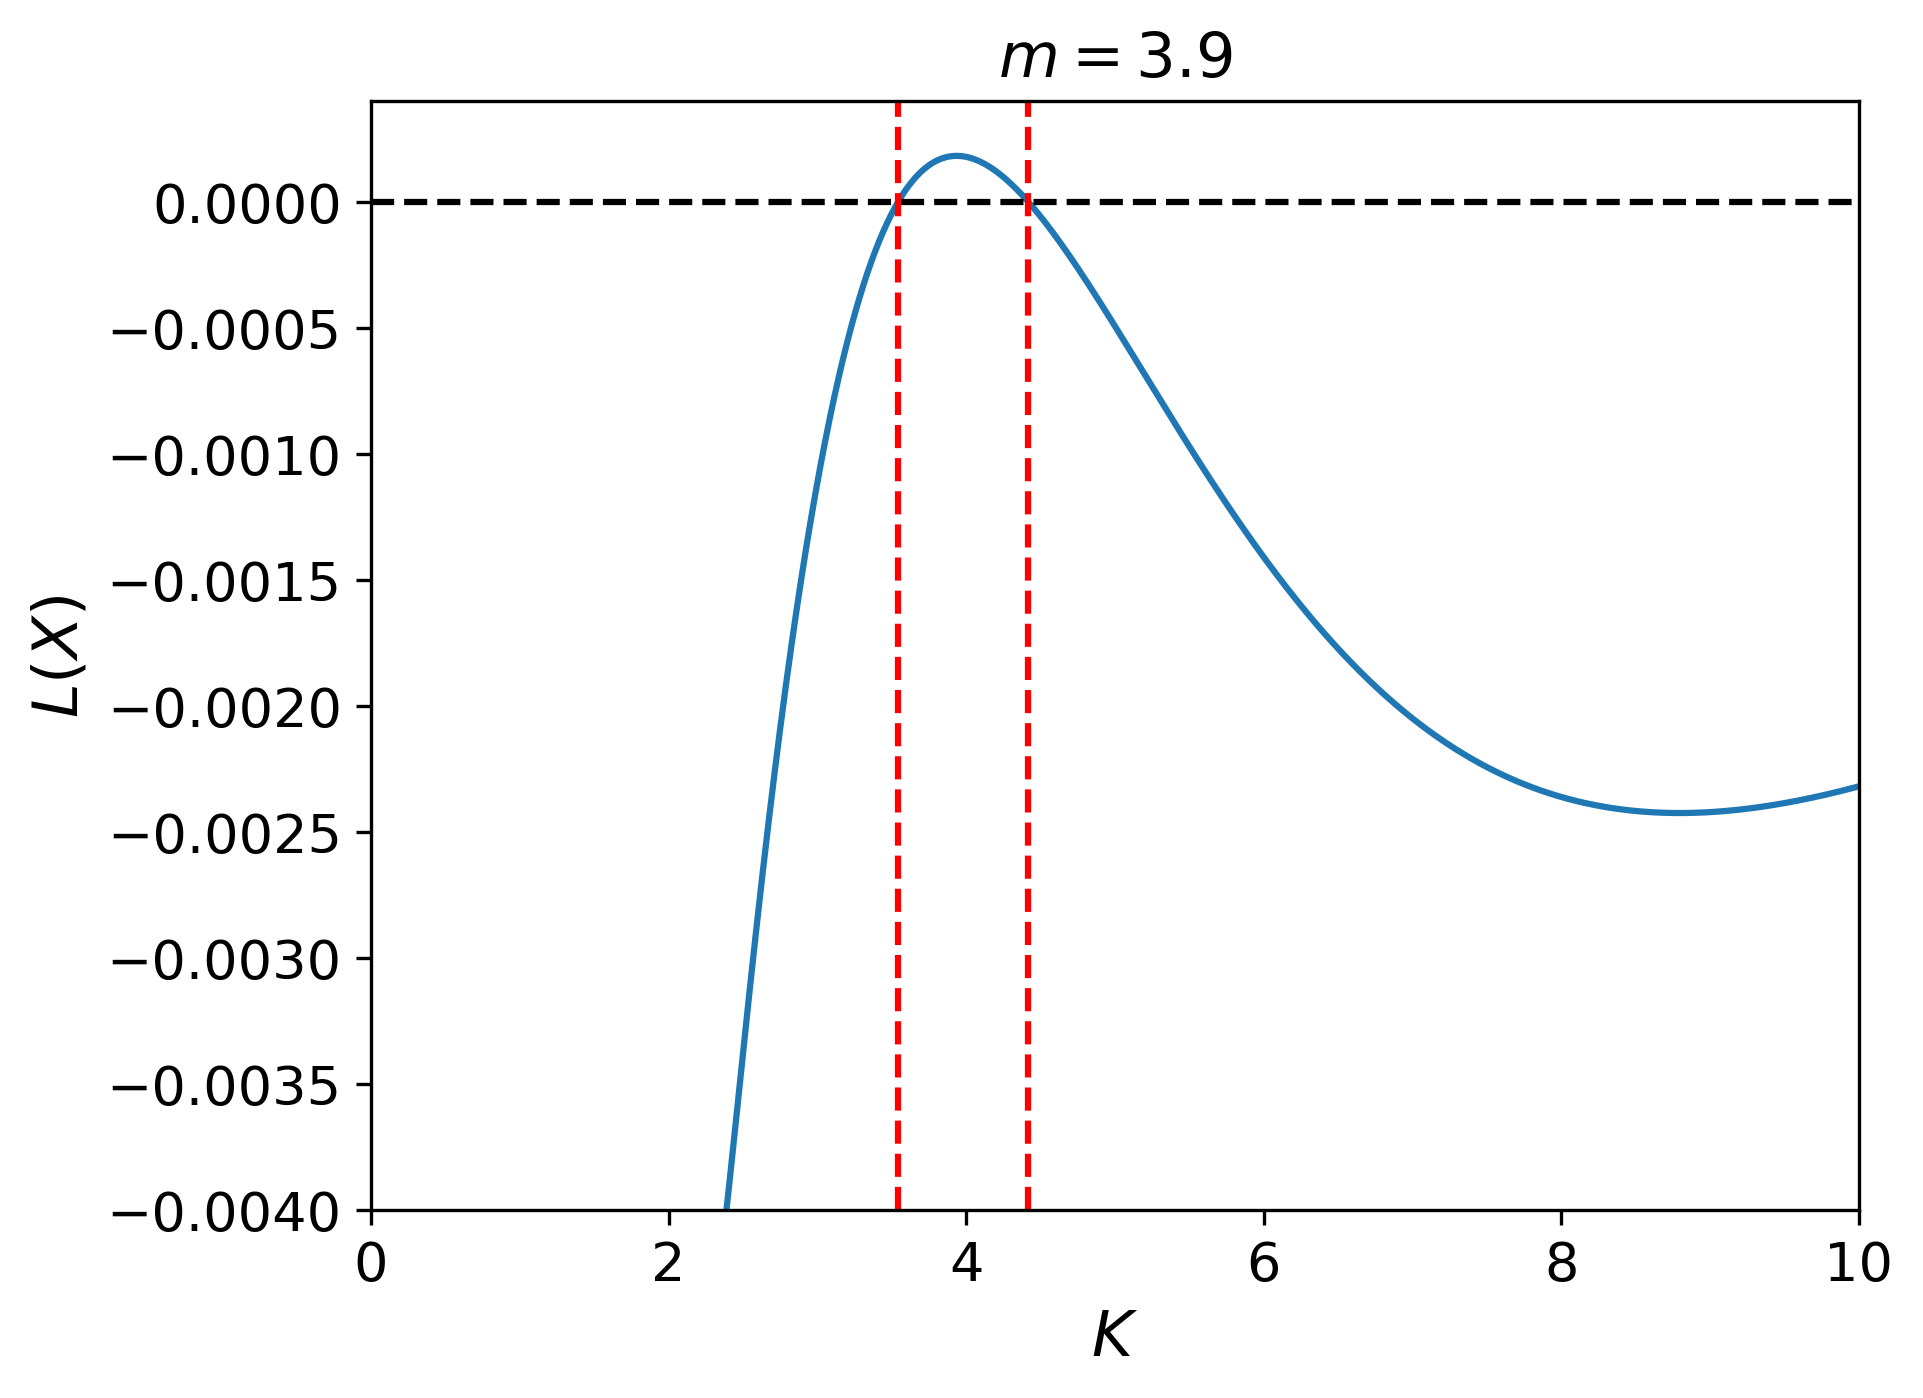

In [113]:
x, = np.where(RPS+R_du/2>=0)
plt.plot(K_u,RPS+R_du/2)
plt.axhline(0,ls='--',color='black')
plt.xlabel(r'$K$',fontsize=15)
# plt.ylabel(r'$r_+(X)+r_{\rm{drift}}(X)/2$',fontsize=15)
plt.ylabel(r'$L(X)$')
plt.ylim(-0.004,0.0004)
plt.xlim(0,10)
plt.axvline(K_u[x[0]],color='red',ls='--')
plt.axvline(K_u[x[-1]],color='red',ls='--')
plt.title(rf'$m={m}$',fontsize=15)
# plt.plot(K_d,RPSd+R_dd/2)

In [323]:
print(K_u[x[-1]])

9.387043567333603


In [744]:
x, = np.where(RPS+R_du/2>=0)
plt.plot(K_u,RPS+R_du/2)
plt.axhline(0,ls='--',color='black')
plt.xlabel(r'$K(X)$',fontsize=15)
plt.ylabel(r'$r_+(X)+r_{\rm{drift}}(X)/2$',fontsize=15)

plt.axvline(K_u[x[0]],color='red',ls='--')
plt.axvline(K_u[x[-1]],color='red',ls='--')
plt.title(rf'$m={m}$',fontsize=15)

ValueError: operands could not be broadcast together with shapes (4984,) (985,) 

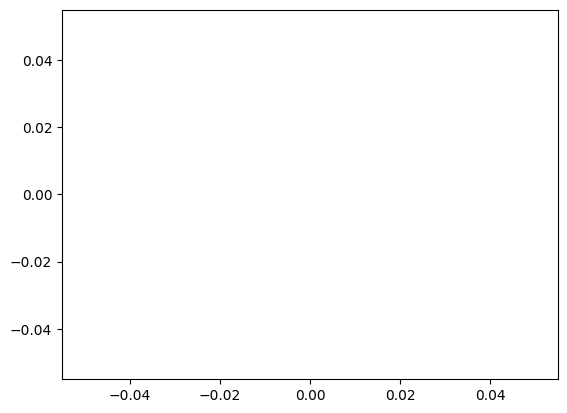

In [1480]:
plt.plot(K1p,RP1_u)
plt.plot(K1p,RP1_d)

In [386]:
np.max(np.diff(K_u)),np.max(Kp),np.max(K1p)

(0.019512806275034933, 7.069041117236938, 7.069041117236938)

In [816]:
m

4.5

In [53]:
F_rN = get_r_rp(m,0,K_max=15,K_len=401)

/Users/kimgug-young/Desktop/KURAMOTO 1st order/Kuramoto-model/TO_sim/Get_2ndR_NORM.py:157: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  I_l,err = quad(integrand_Rl2, shift_O,+omega_p,args=(X,O_pm,shift_O,m),limit=200)
/Users/kimgug-young/Desktop/KURAMOTO 1st order/Kuramoto-model/TO_sim/Get_2ndR_NORM.py:158: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  I_d,err = quad(integrand_Rd2, omega_p,np.inf,args=(X,O_pm,shift_O,m),limit=200)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/lib/function_base.py:2455: RuntimeWarning: invalid value encountered in F_sec (vectorized)
  outputs = ufunc(*inputs)


In [316]:
df = pd.read_excel('N = 5000 seed = 10 QNORMAL wo pv.xlsm')
Ks_ = np.arange(0,10.05,0.1)

In [253]:
m = 5

In [312]:
K = 10
# rs = np.linspace(0,1,10000)[1:]
Xs1 = np.logspace(-15,-3,2000)
Xs = np.r_[Xs1,np.linspace(1e-3,60,10001)]

R_ls = []
R_drs = []


for X in Xs:
    a = 1/np.sqrt(X*m)
    b = 4/np.pi * a - 0.3056*a**3
    b = np.where(np.where(a>1.193,1,b)>=1,1,b)

    omega_p = b*X
    R_l,err = quad(integrand_Rl, -omega_p,omega_p,args=(X,0,1,m),limit=200)
    R_dr,err = quad(integrand_Rd,omega_p,np.inf,args=(X,0,1,m),limit=200)
    R_ls.append(R_l)
    R_drs.append(R_dr)


R0 = np.array(R_ls)
RD = 2*np.array(R_drs)
R = R0 -RD
KK = 1/(R/Xs)
K_min_arg = np.argmin(KK)

K_d = KK[:K_min_arg]
K_u = KK[K_min_arg:]
r_d = Xs[:K_min_arg]/K_d
r_u = Xs[K_min_arg:]/K_u
R_0d = R0[:K_min_arg]
R_0u = R0[K_min_arg:]
R_dd = -RD[:K_min_arg]
R_du = -RD[K_min_arg:]

R_u = R_0u + R_du
R_d = R_0d + R_dd
K_start = KK[K_min_arg]
Xsu = Xs[K_min_arg:]
Xsd = Xs[:K_min_arg]

a = 1/np.sqrt(Xsu*m)
b = 4/np.pi * a - 0.3056*a**3
b = np.where(np.where(a>1.193,1,b)>=1,1,b)
OPS = b*Xsu


a = 1/np.sqrt(Xsd*m)
b = 4/np.pi * a - 0.3056*a**3
b = np.where(np.where(a>1.193,1,b)>=1,1,b)
OPSd = b*Xsd


In [255]:
F = get_r_Fun(m)

In [256]:
df

,K,m,S0,S+,S-,rm,r0,r+,r-,r+_total,r-_total,sig,sig+_total,sig-_total,v0,v+,v-
0,0.0,0.0,5000.0,NaN,NaN,0.013262,0.012602,NaN,NaN,0.000000,0.000000,0.007512,0.000000,0.000000,0.000000,NaN,NaN
1,NaN,0.1,NaN,NaN,NaN,0.013263,NaN,NaN,NaN,0.009809,0.007807,0.007512,0.005150,0.003732,NaN,NaN,NaN
2,NaN,0.2,NaN,NaN,NaN,0.013261,NaN,NaN,NaN,0.009804,0.007788,0.007513,0.005150,0.003720,NaN,NaN,NaN
3,NaN,0.3,NaN,NaN,NaN,0.013257,NaN,NaN,NaN,0.009801,0.007769,0.007516,0.005150,0.003708,NaN,NaN,NaN
4,NaN,0.4,NaN,NaN,NaN,0.013252,NaN,NaN,NaN,0.009802,0.007750,0.007519,0.005150,0.003697,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10196,NaN,9.6,4120.0,266.0,247.0,0.792079,0.820892,0.051184,0.047415,0.048689,0.045132,0.063387,0.003996,0.003510,-0.007055,1.436335,-1.450471
10197,NaN,9.7,4110.0,269.0,249.0,0.792970,0.818916,0.051845,0.047859,0.049257,0.045237,0.064285,0.003672,0.003747,-0.007697,1.433071,-1.448686
10198,NaN,9.8,4105.0,273.0,252.0,0.793757,0.817926,0.052619,0.048485,0.050035,0.045915,0.065660,0.003747,0.003739,-0.007322,1.434285,-1.448910
10199,NaN,9.9,4112.0,268.0,250.0,0.792167,0.819322,0.051670,0.048097,0.049197,0.045776,0.064276,0.003675,0.003420,-0.005667,1.440471,-1.451719


In [257]:
Ks = np.arange(0,20,0.05)
R_0u = F['u']['R0'](Ks)
idx = np.isnan(R_0u)
K_urp = Ks[~idx]
R_0u = R_0u[~idx]
OPS = F['u']['OPS'](K_urp)
Ks,rp_d,rp_u,rp0_d,rp0_u = get_rp(K_urp,R_0u,OPS,MAX=False)
KsM,rpM_d,rpM_u,rpM0_d,rpM0_u = get_rp(K_urp,R_0u,OPS,MAX=True)

In [263]:
K_sd,K_su = get_Kritical(m)

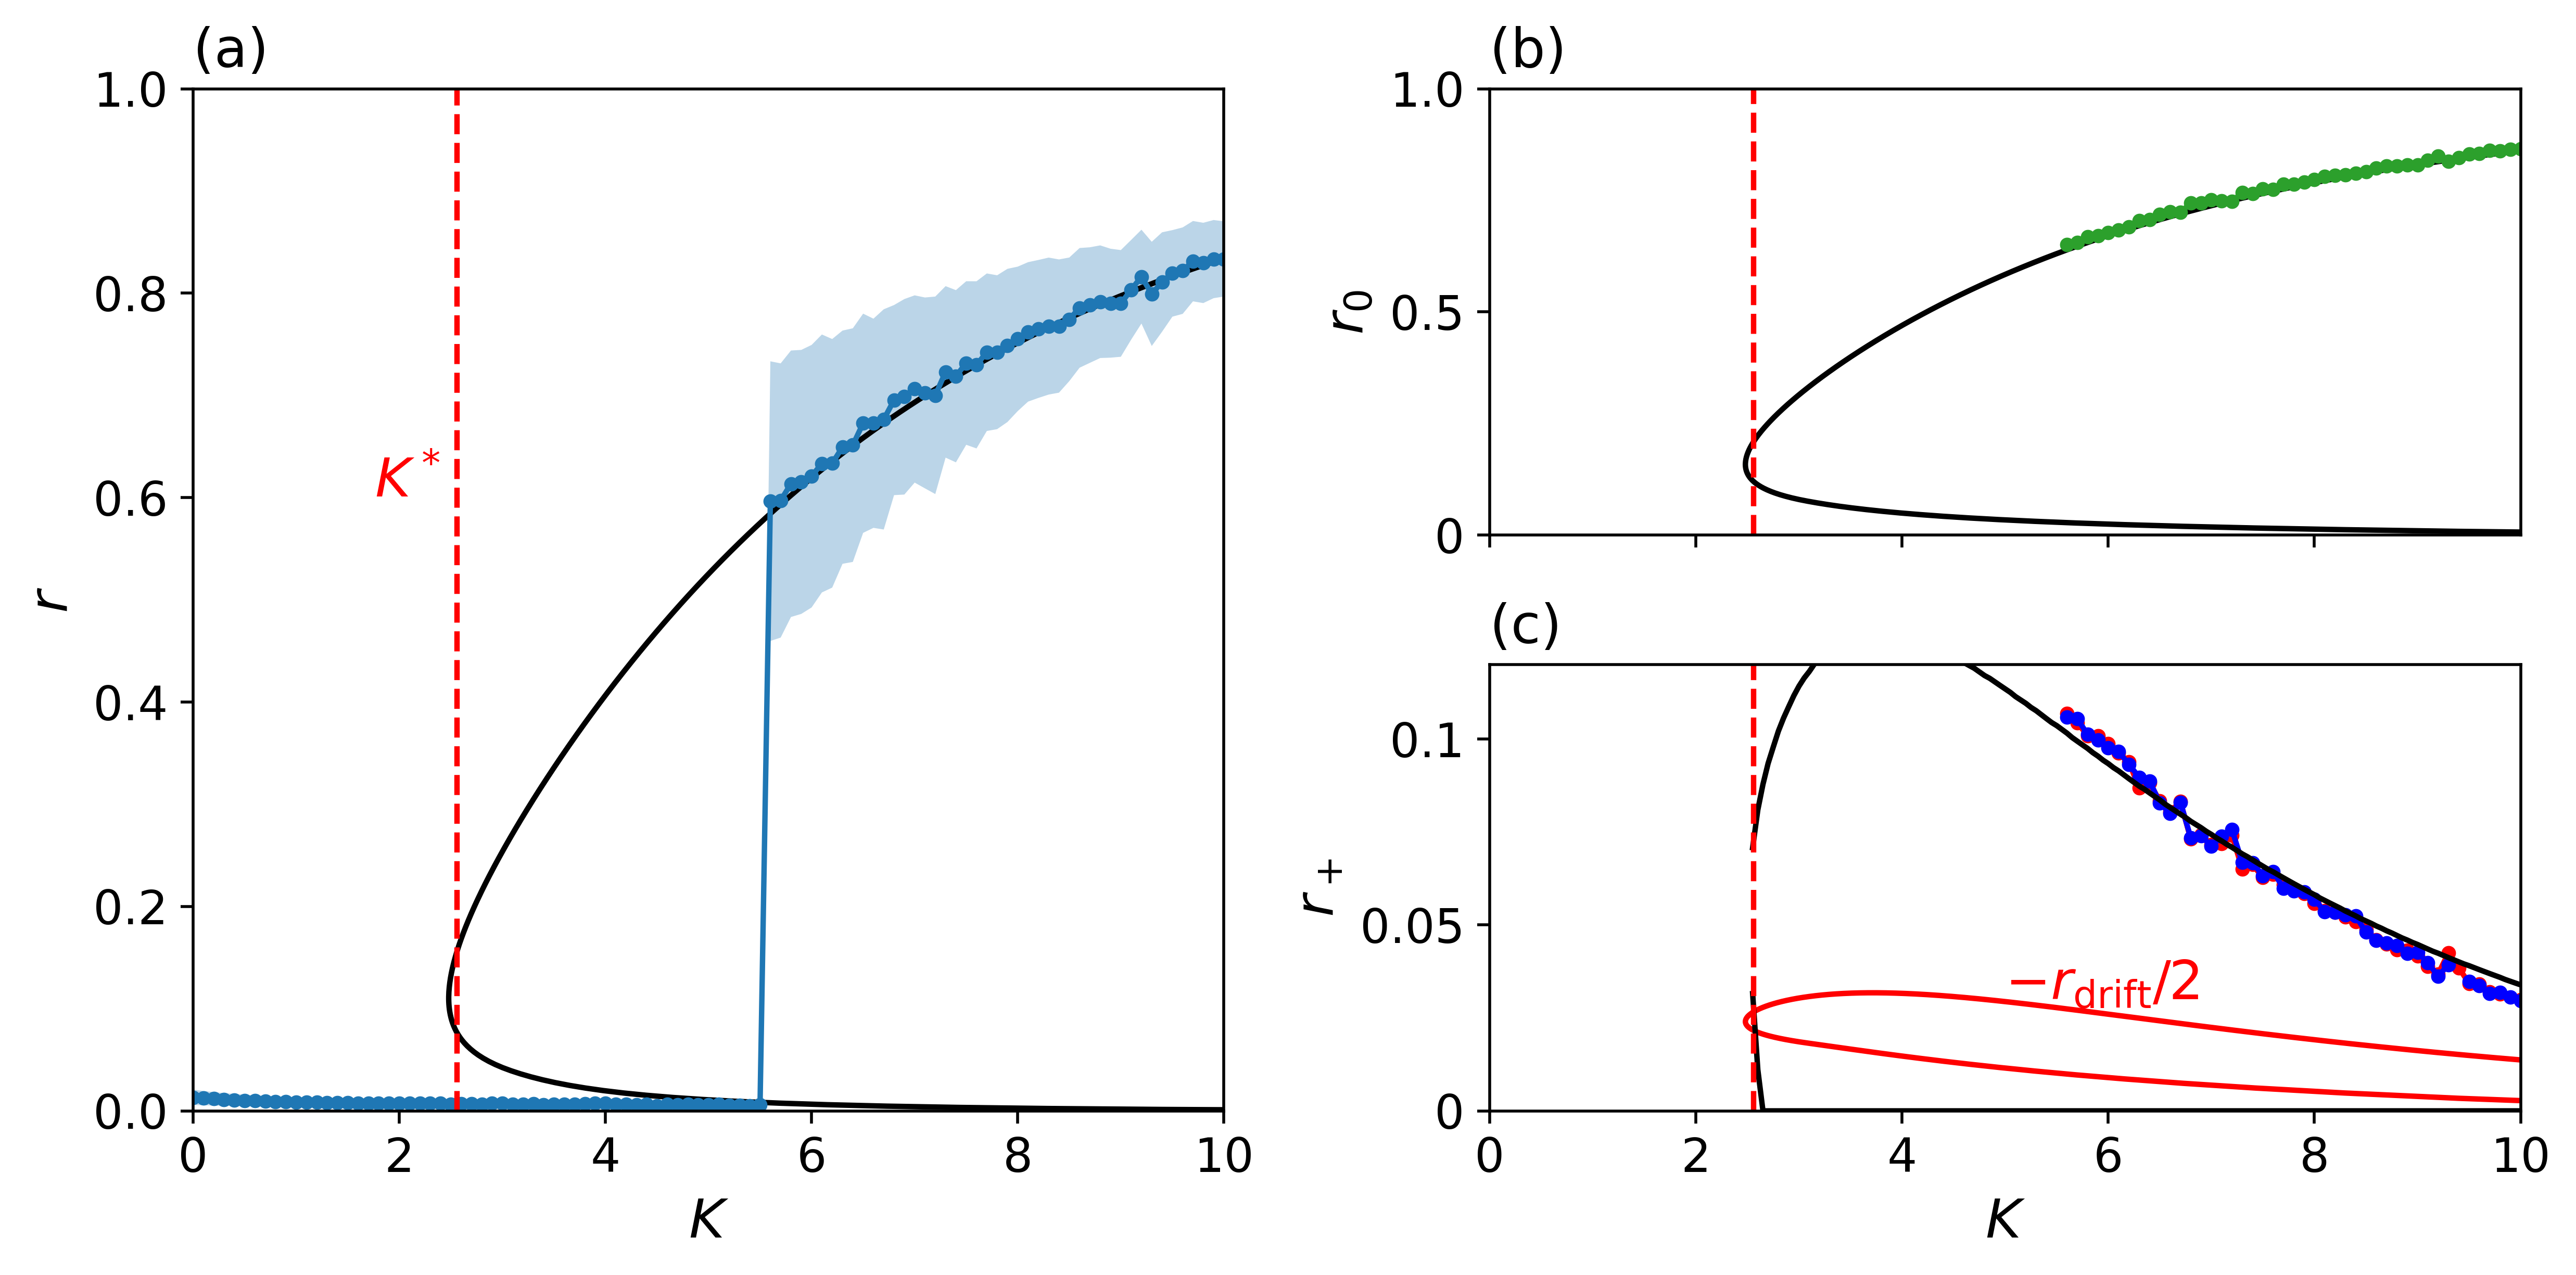

In [315]:
plt.figure(dpi=500,figsize=(10,5))
plt.subplot(121)
plt.plot(KK,Xs/KK,color='black')
plt.xlim(0,10)
plt.ylim(0,1)
plt.plot(Ks_,df[df.m==m]['rm'],'.-')
plt.fill_between(Ks_,df[df.m==m]['rm']-df[df.m==m]['sig'],df[df.m==m]['rm']+df[df.m==m]['sig'],alpha=0.3)
plt.scatter(KK[0],Xs[0]/KK[0],color='black')
plt.axvline(KK[0],ls='--',color='black')
plt.axvline(K_sd,color='red',ls='--')
plt.axvline(K_su,color='red',ls='--')
plt.text(K_sd-0.8,0.6,r'$K^*$',color='red',fontsize=15)

# plt.text(KK[0]+0.3,0.1,r'$K_c$',color='black',fontsize=15)
plt.title('(a)',loc='left')
plt.xlabel(r'$K$')
plt.ylabel(r'$r$')

plt.subplot(222)
plt.plot(KK,R0,color='black')
plt.xlim(0,10)
plt.ylim(0,1)
plt.plot(Ks_,df[df.m==m]['r0'],'.-',color='tab:green')
# plt.fill_between(Ks_,df[df.m==m]['r0']-df[df.m==m]['S0'],df[df.m==m]['r0']+df[df.m==m]['S0'],alpha=0.3)
plt.scatter(KK[0],Xs[0]/KK[0],color='black')
plt.axvline(KK[0],ls='--',color='black')

plt.axvline(K_sd,color='red',ls='--')
plt.axvline(K_su,color='red',ls='--')

# plt.text(KK[0]+0.3,0.1,r'$K_c$',color='black',fontsize=15)
# plt.xlabel(r'$K$')
plt.ylabel(r'$r_0$')
plt.yticks([0,0.5,1.0],[0,0.5,1.0])
plt.xticks([0,2,4,6,8],[])
plt.title('(b)',loc='left')

plt.subplot(224)
# plt.plot(KK,R0,color='black')
plt.xlim(0,10)
plt.ylim(0,0.12)
plt.plot(Ks_,df[df.m==m]['r+'],'.-',color='red')
plt.plot(Ks_,df[df.m==m]['r-'],'.-',color='blue')
# plt.fill_between(Ks_,df[df.m==m]['r0']-df[df.m==m]['S0'],df[df.m==m]['r0']+df[df.m==m]['S0'],alpha=0.3)
plt.plot(KK,RD/2,color='red')
plt.plot(Ks,rp_u,color='black')
plt.plot(Ks,rp_d,color='black')

plt.axvline(K_sd,color='red',ls='--')
plt.axvline(K_su,color='red',ls='--')

plt.axvline(KK[0],ls='--',color='black')
# plt.text(KK[0]+0.3,0.01,r'$K_c$',color='black',fontsize=15)
plt.text(5,0.030,r'$-r_{\rm{drift}}/2$',color='red',fontsize=15)
plt.yticks([0,0.05,0.1],[0,0.05,0.1])
plt.title('(c)',loc='left')

plt.xlabel(r'$K$')
plt.ylabel(r'$r_+$')
plt.tight_layout()

In [567]:
K[~np.isnan(rp_u)]

array([ 2.83432736,  2.85592854,  2.87752732,  2.89911496,  2.92068391,
        2.94222772,  2.96374085,  2.98521856,  3.00665681,  3.02805214,
        3.04940166,  3.07070289,  3.0919538 ,  3.11315267,  3.13429812,
        3.15538902,  3.17642448,  3.19740383,  3.21832656,  3.23919234,
        3.26000098,  3.28075239,  3.30144662,  3.32208379,  3.34266412,
        3.36318788,  3.38365543,  3.40406717,  3.42442355,  3.44472506,
        3.46497222,  3.4851656 ,  3.50530577,  3.52539333,  3.54542892,
        3.56541317,  3.58534673,  3.60523026,  3.62506442,  3.64484989,
        3.66458735,  3.68427748,  3.70392094,  3.72351844,  3.74307063,
        3.7625782 ,  3.78204182,  3.80146216,  3.82083988,  3.84017564,
        3.8594701 ,  3.87872389,  3.89793766,  3.91711205,  3.93624768,
        3.95534516,  3.97440511,  3.99342814,  4.01241483,  4.03136578,
        4.05028157,  4.06916277,  4.08800994,  4.10682364,  4.12560442,
        4.14435281,  4.16306936,  4.18175457,  4.20040898,  4.21

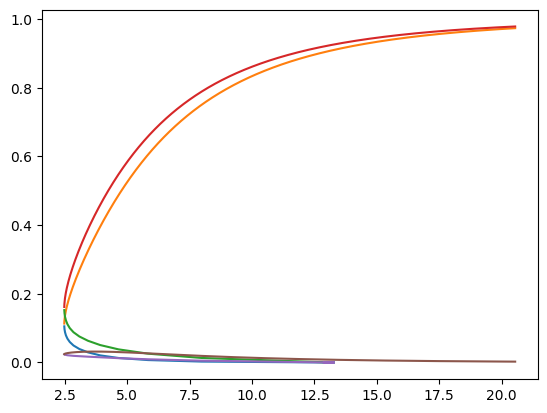

In [272]:
plt.plot(K_d,r_d)
plt.plot(K_u,r_u)
plt.plot(K_d,R_0d)
plt.plot(K_u,R_0u)


plt.plot(K_d,-R_dd/2)
plt.plot(K_u,-R_du/2)

# get sigma

In [ ]:
2*rp*np.sqrt(1/2 - m*K*r0/(4*(4*m**2*O_pm**2 +1)) - (m*K*r0/(2*(m**2*O_pm**2+1))**2))

In [309]:
m = 6
F = get_r_Fun(m)
Ks = np.arange(0,20,0.05)
R_0u = F['u']['R0'](Ks)
idx = np.isnan(R_0u)
K_urp = Ks[~idx]
R_0u = R_0u[~idx]
OPS = F['u']['OPS'](K_urp)
Ks,rp_d,rp_u,rp0_d,rp0_u = get_rp(K_urp,R_0u,OPS,MAX=False)
sig_u =2*rp_u*np.sqrt(1/2 - m*Ks*R_0u/(4*(4*m**2*OPS**2 +1)) - (m*Ks*R_0u/(2*(m**2*OPS**2+1))**2))
sig_d =2*rp_d*np.sqrt(1/2 - m*Ks*R_0u/(4*(4*m**2*OPS**2 +1)) - (m*Ks*R_0u/(2*(m**2*OPS**2+1))**2))
K_sd,K_su = get_Kritical(m)

4.9

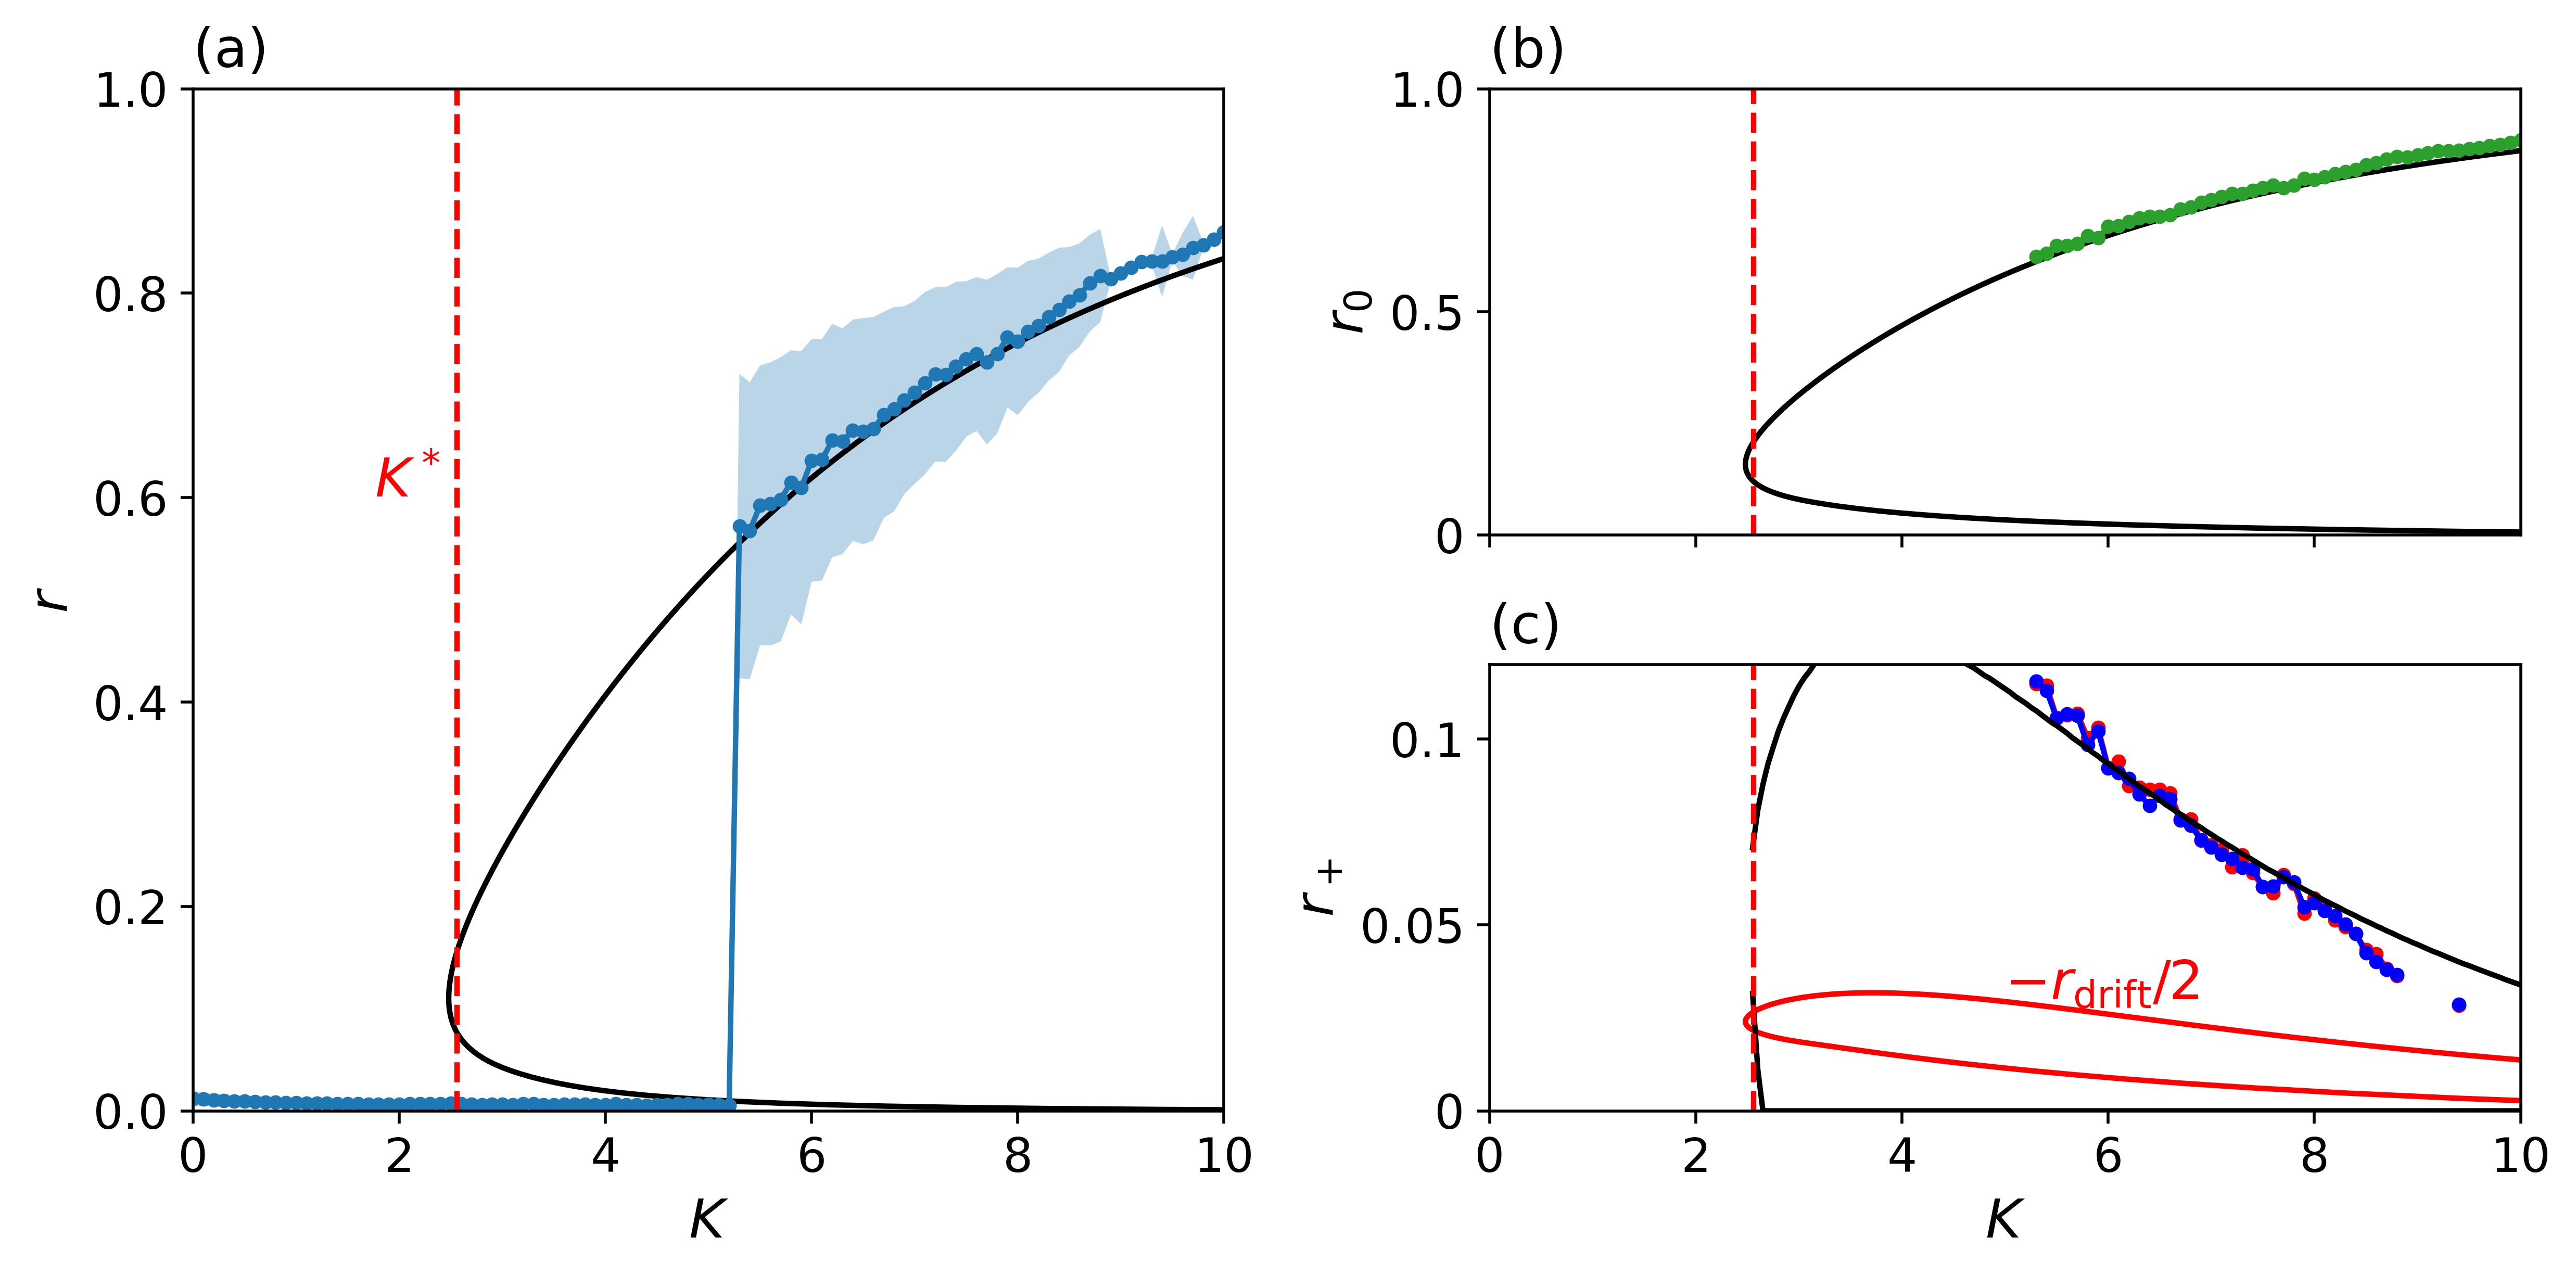

In [313]:
plt.figure(dpi=500,figsize=(10,5))
plt.subplot(121)
plt.plot(KK,Xs/KK,color='black')
plt.xlim(0,10)
plt.ylim(0,1)
plt.plot(Ks_,df[df.m==m]['rm'],'.-')
plt.fill_between(Ks_,df[df.m==m]['rm']-df[df.m==m]['sig'],df[df.m==m]['rm']+df[df.m==m]['sig'],alpha=0.3)
plt.scatter(KK[0],Xs[0]/KK[0],color='black')
plt.axvline(KK[0],ls='--',color='black')
plt.axvline(K_sd,color='red',ls='--')
plt.axvline(K_su,color='red',ls='--')
plt.text(K_sd-0.8,0.6,r'$K^*$',color='red',fontsize=15)

# plt.text(KK[0]+0.3,0.1,r'$K_c$',color='black',fontsize=15)
plt.title('(a)',loc='left')
plt.xlabel(r'$K$')
plt.ylabel(r'$r$')

plt.subplot(222)
plt.plot(KK,R0,color='black')
plt.xlim(0,10)
plt.ylim(0,1)
plt.plot(Ks_,df[df.m==m]['r0'],'.-',color='tab:green')
# plt.fill_between(Ks_,df[df.m==m]['r0']-df[df.m==m]['S0'],df[df.m==m]['r0']+df[df.m==m]['S0'],alpha=0.3)
plt.scatter(KK[0],Xs[0]/KK[0],color='black')
plt.axvline(KK[0],ls='--',color='black')

plt.axvline(K_sd,color='red',ls='--')
plt.axvline(K_su,color='red',ls='--')

# plt.text(KK[0]+0.3,0.1,r'$K_c$',color='black',fontsize=15)
# plt.xlabel(r'$K$')
plt.ylabel(r'$r_0$')
plt.yticks([0,0.5,1.0],[0,0.5,1.0])
plt.xticks([0,2,4,6,8],[])
plt.title('(b)',loc='left')

plt.subplot(224)
# plt.plot(KK,R0,color='black')
plt.xlim(0,10)
plt.ylim(0,0.12)
plt.plot(Ks_,df[df.m==m]['r+'],'.-',color='red')
plt.plot(Ks_,df[df.m==m]['r-'],'.-',color='blue')
# plt.fill_between(Ks_,df[df.m==m]['r0']-df[df.m==m]['S0'],df[df.m==m]['r0']+df[df.m==m]['S0'],alpha=0.3)
plt.plot(KK,RD/2,color='red')
plt.plot(Ks,rp_u,color='black')
plt.plot(Ks,rp_d,color='black')

plt.axvline(K_sd,color='red',ls='--')
plt.axvline(K_su,color='red',ls='--')

plt.axvline(KK[0],ls='--',color='black')
# plt.text(KK[0]+0.3,0.01,r'$K_c$',color='black',fontsize=15)
plt.text(5,0.030,r'$-r_{\rm{drift}}/2$',color='red',fontsize=15)
plt.yticks([0,0.05,0.1],[0,0.05,0.1])
plt.title('(c)',loc='left')

plt.xlabel(r'$K$')
plt.ylabel(r'$r_+$')
plt.tight_layout()

Text(0, 0.5, '$\\sigma_r$')

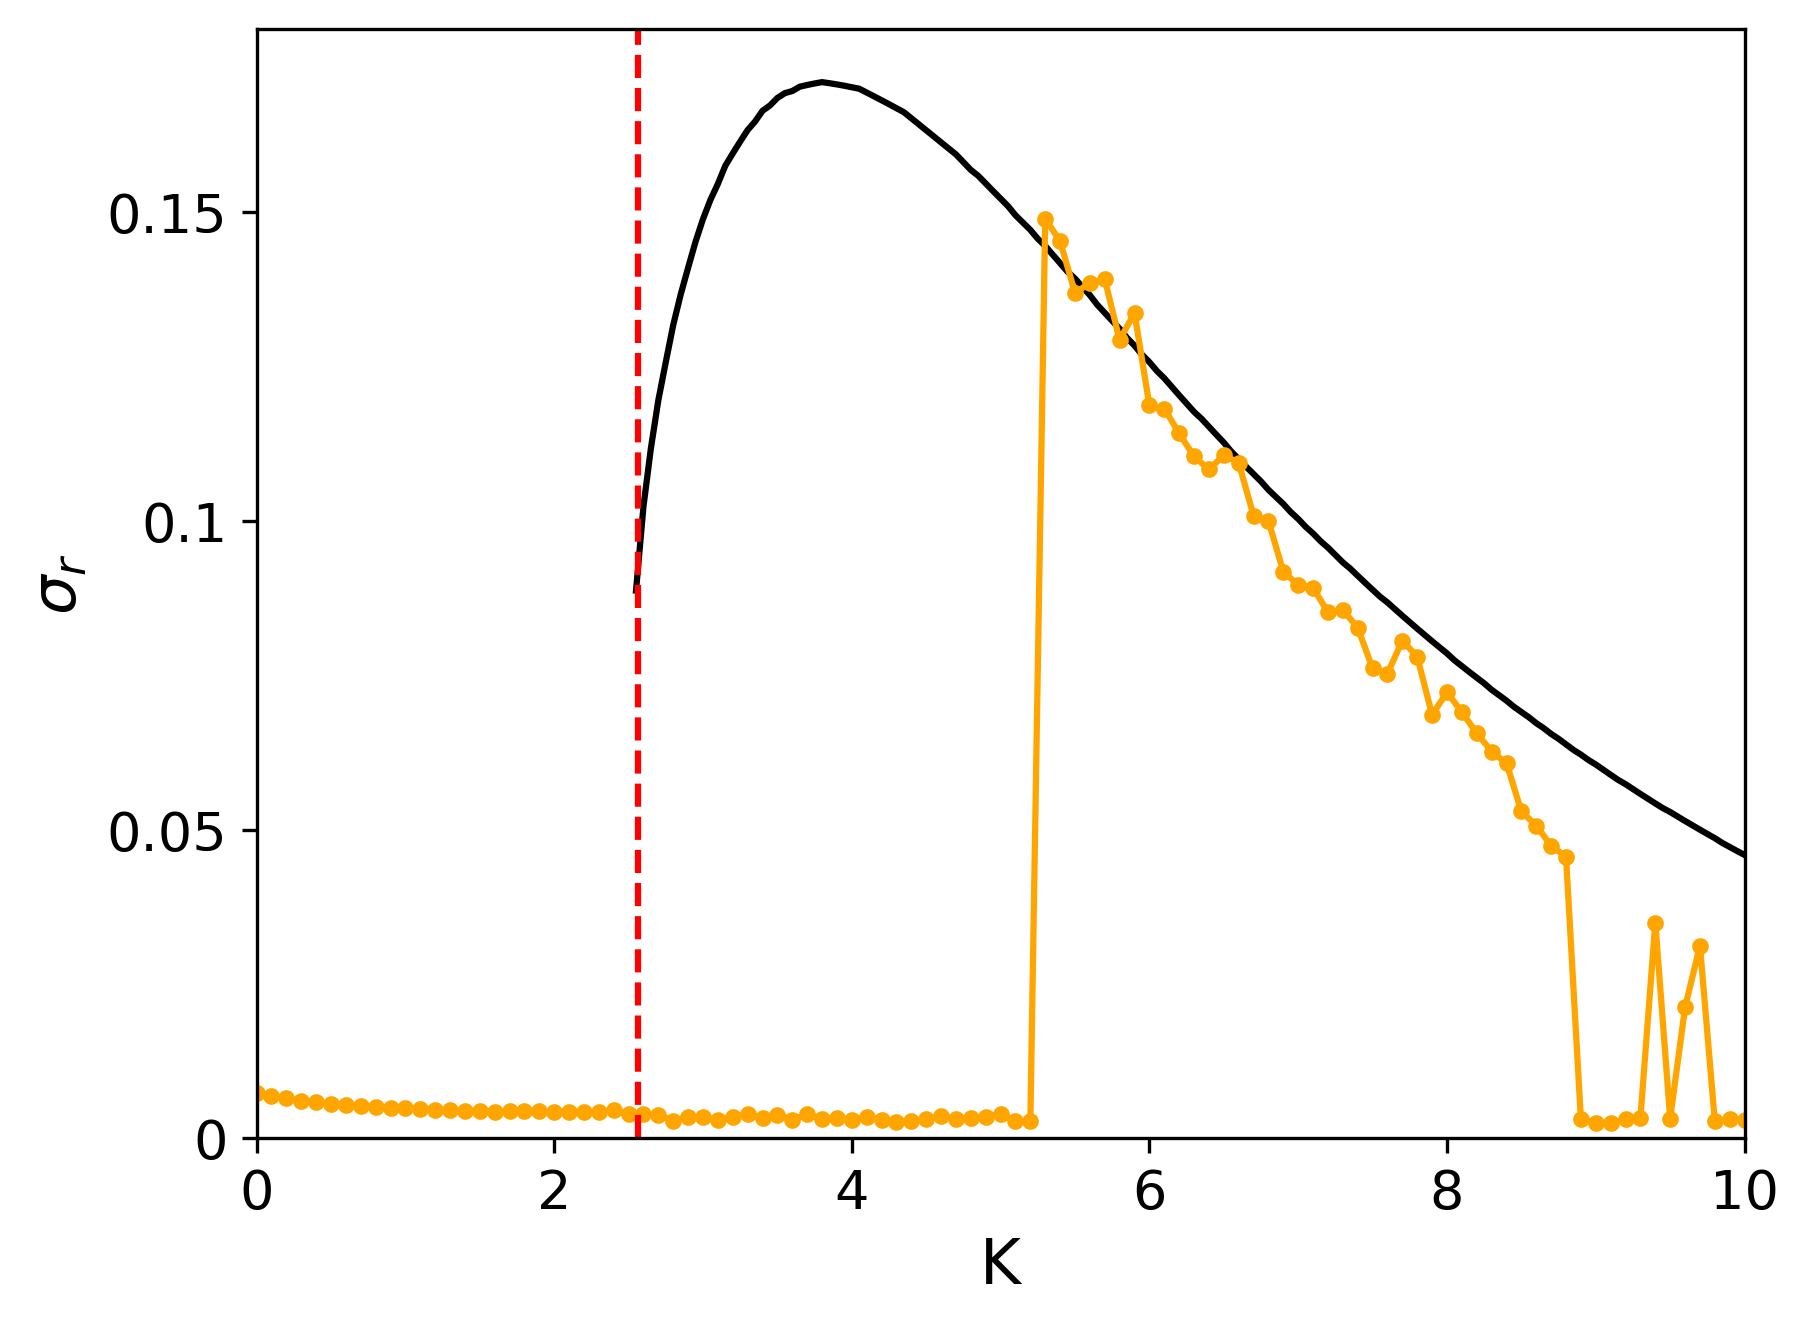

In [310]:
plt.plot(Ks,sig_u,color='black')
plt.plot(Ks_,df[df.m==m]['sig'],'.-',color='orange')
# plt.plot(Ks,sig_d)
plt.ylim(0,)
plt.yticks([0,0.05,0.1,0.15],[0,0.05,0.1,0.15])

plt.axvline(K_sd,color='red',ls='--')
plt.axvline(K_su,color='red',ls='--')
plt.xlim(0,10)
plt.xlabel('K')
plt.ylabel('$\sigma_r$')


In [273]:
plt.plot(Xs,RL -RD)
# plt.ylim(-0.001,0.01)
# plt.xscale('log')
# plt.plot(rs,rs)

ValueError: operands could not be broadcast together with shapes (11000,) (2001,) 

In [27]:
import numpy as np
import matplotlib.pyplot as plt

from TO_sim.Sol_Kuramoto import Sol_Kuramoto_mK as mK
from TO_sim.Sol_Kuramoto import Sol_Kuramoto_mf2 as mf2


from TO_sim.gen_Distribution import Quantile_Normal as Q_Normal
from TO_sim.gen_Distribution import Quantile_Lorentzian as Q_Lorentzian

from TO_sim.get_cluster import cluster_os_new2

In [28]:
avg_dthetas = {}
r_c = {}

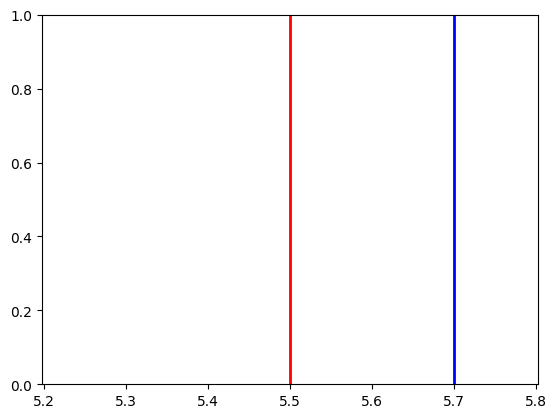

In [29]:

plt.axvline(5.5,lw=2,color='red')
plt.axvline(5.7,lw=2,color='blue')

In [903]:
K_1,K_0

(5.229188516950889, 3.269315251234632)

In [985]:
seed =11
N = 2000
theta_random,omega,Kc = Q_Normal(N,0,1,seed=seed)
# theta_random,omega,Kc = Q_Lorentzian(N,0,1,seed=seed)

omega = omega - np.mean(omega)
omega = np.sort(omega)
dt = 0.1
t = np.arange(0,3000,dt)
# K = 5.3
K = 4.5
to_ppi = lambda y: (y + np.pi)%(2*np.pi) - np.pi
theta, dtheta,rs = mf2(K,N=N,m=m,t_array=t,p_theta=theta_random,p_dtheta=omega,p_omega=omega)
# plt.plot(np.sort(avg_dtheta[-1]))
# plt.plot((avg_dtheta[-1]))

In [986]:
del dtheta

In [987]:
avg_dtheta = (theta[-50:] - theta[-1051:-1001])/(100)

In [1000]:
CS,CMP,cluster,_,_,_,_,_,_ =cluster_os_new2(avg_dtheta[-2:],height=0.01,check=2,c_size=1,omega=omega)

CS

array([1482])

In [995]:
cluster.astype(int)

ValueError: setting an array element with a sequence.

In [996]:
r0_ = np.mean(np.abs(np.sum(np.exp(1j*theta[-500:,cluster[0].astype(int)]),axis=1))/N)


In [997]:
rp = np.mean(np.abs(np.sum(np.exp(1j*theta[-500:,cluster[1]]),axis=1))/N)

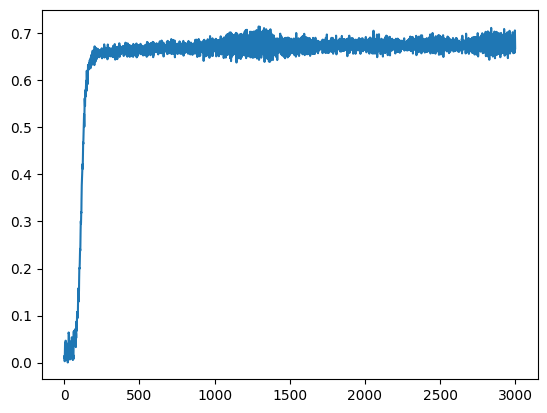

In [998]:
plt.plot(t,rs)

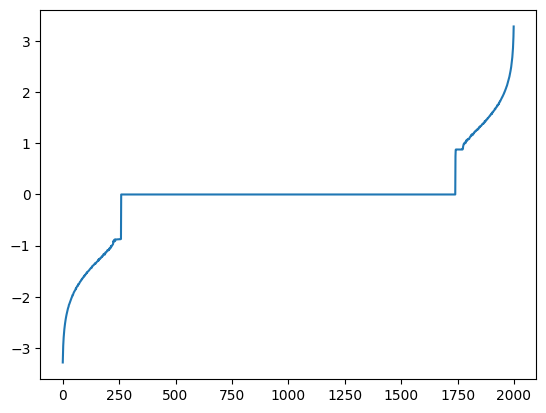

In [1002]:
plt.plot(avg_dtheta[-1])
# plt.scatter(cluster[1],avg_dtheta[-1,cluster[1]])

# Foward new

In [1099]:
from parfor import parfor
import TO_sim.Q_simul as QSIM

import TO_sim.Integrator_jit as IJ
from TO_sim.Kuramoto_model import Kuramoto_2nd_mf,Kuramoto_1st_mf
from TO_sim.Q_simul import Q_Normal, Q_Lorentz
import numpy as np, matplotlib.pyplot as plt
from TO_sim.get_cluster import cluster_os_new2
import pandas as pd
from tqdm.notebook import tqdm
RK4_jit_short = IJ.RK4_short

func = Kuramoto_2nd_mf
func1 = Kuramoto_1st_mf

In [1253]:
N = 500

seed =8

theta_random,omega,Kc = Q_Normal(N,0,1,seed=seed)
# theta_random,omega,Kc = Q_Lorentz(N,0,1,seed=seed)

omega = omega - np.mean(omega)
omega = np.sort(omega)
m = 6
dt = 0.1
t = np.arange(0,2000,dt)
# K = 5.5
L = 5000
to_ppi = lambda y: (y + np.pi)%(2*np.pi) - np.pi
# theta, dtheta,rs = mf2(K,N=N,m=m,t_array=t,p_theta=theta_random,p_dtheta=theta_random,p_omega=omega)
# plt.plot(np.sort(avg_dtheta[-1]))
# plt.plot((avg_dtheta[-1]))
Theta = np.r_[theta_random,omega]
Ks = np.arange(0,15+0.1/2,0.1)

In [1254]:
theta_s = np.zeros((len(Ks),2000,N))
dtheta_s = np.zeros((len(Ks),2000,N))
df_s = []
for i,K in tqdm(list(enumerate(Ks))):
    sol = RK4_jit_short(func,Theta,t, args=(omega, N,m, K),result_time=int(t[-6000]/dt))
    theta = sol[:,:N]
    dtheta = sol[:,N:]
    rs = np.abs(np.mean(np.exp(1j*theta[-L:]),axis=1))
    r = np.mean(rs)
    std = np.std(rs)
    avg_dtheta = (theta[1000:] - theta[:-1000])/(100)
    CS,CMP,cluster,_,_,_,_,_,_ =cluster_os_new2(avg_dtheta[-50:],height=0.01,check=2,c_size=1,omega=omega)
    while (r > 1/np.sqrt(N)) and std > 0.05 and len(CS) == 1:
        print('asdfasdf')
        sol = RK4_jit_short(func,Theta,t, args=(omega, N,m, K),result_time=int(t[-6000]/dt))
        theta = sol[:,:N]
        dtheta = sol[:,N:]
        rs = np.abs(np.mean(np.exp(1j*theta[-L:]),axis=1))
        r = np.mean(rs)
        std = np.std(rs)
        avg_dtheta = (theta[1000:] - theta[:-1000])/(100)
        CS,CMP,cluster,_,_,_,_,_,_ =cluster_os_new2(avg_dtheta[-50:],height=0.01,check=2,c_size=1,omega=omega)
        theta[-1] = (theta[-1]+np.pi)%(2*np.pi) - np.pi
        Theta = np.r_[theta[-1],dtheta[-1]]
    avg_dtheta = (theta[1000:] - theta[:-1000])/(100)
    theta_s[i] = theta[-2000:]
    dtheta_s[i] = dtheta[-2000:]
    theta[-1] = (theta[-1]+np.pi)%(2*np.pi) - np.pi
    Theta = np.r_[theta[-1],dtheta[-1]]
    del theta,dtheta,sol
    

  0%|          | 0/151 [00:00<?, ?it/s]

asdfasdf
asdfasdf
asdfasdf
asdfasdf
asdfasdf
asdfasdf


In [1255]:
df_s = []
i = 0
for theta in theta_s:
    gs = {}
    avg_dtheta = (theta[500:] - theta[:-500])/(50)
    CS,CMP,cluster,_,_,_,_,_,_ =cluster_os_new2(avg_dtheta[-3:-1],height=0.001,check=2,c_size=1,omega=omega)
    print(CS)

[]
[]
[2 2]
[2 2 2]
[2 2 2]
[2 2 2]
[3]
[3 2 2]
[]
[3 2 2]
[2 2 2]
[]
[3 3 3]
[3 2]
[3 3]
[3]
[2 2]
[3 3 3]
[]
[3]
[3 3 3]
[]
[]
[2]
[3]
[3 3 3]
[4]
[4 4 4]
[4 3 3]
[4 4 3]
[4 3 3]
[5 4]
[5 4]
[3 3 3]
[3 3 3]
[6 3]
[4 3]
[4 4 3]
[3]
[5]
[4]
[4]
[4]
[4 4 3]
[6]
[292   5]
[293  66  65]
[293  69  68]
[293  70  70]
[293  70  70]
[293  72  70]
[293  72  71]
[293  75  73]
[293]
[293  75  44]
[293  75  45]
[306  75  64]
[306  63  42]
[306  66  62]
[319  58  57]
[329]
[334  49  29]
[365  46  33]
[365  38  29]
[365  36]
[365  49  37]
[365  49  37]
[365  50  38]
[365  50  38]
[365  40  25]
[365  51  39]
[365  40  27]
[365  37  26]
[381  38  37]
[381  38  37]
[381]
[381  38  34]
[381  35  32]
[385]
[387  30  28]
[392  31  25]
[396  32  26]
[397  31  20]
[400  32  20]
[401  31  28]
[401  31  16]
[403   5]
[410  27  24]
[410  25  17]
[414]
[418  18   7]
[418  24  20]
[425  10   3]
[425  20  19]
[425  19  16]
[425  16  12]
[425  10   8]
[428  14  14]
[428  15   9]
[434   8]
[434]
[434  17  16]
[434 

In [1257]:
def assign_group_by_tolerance(df, tolerance):
    group_number = 0
    current_group_start = df['group abs rot'][0]  # 첫번째 값이 그룹의 시작 기준
    # 첫번째 값에 그룹 번호 할당
    df.at[0, 'Group'] = group_number
    
    # 두번째 값부터 확인하면서 그룹을 할당
    for i in range(1, len(df)):
        # 현재 값이 그룹 시작 값으로부터 tolerance 안에 있으면 같은 그룹으로 묶음
        if df['group abs rot'][i] - current_group_start <= tolerance:
            df.at[i, 'Group'] = group_number
        else:
            # 그룹 시작 값보다 tolerance를 벗어나면 새로운 그룹을 할당
            group_number += 1
            current_group_start = df['group abs rot'][i]  # 새로운 그룹 시작 값 갱신
            df.at[i, 'Group'] = group_number

    return df

def Get_Group(theta,t,L):
    th = (theta[-1]-theta[-L])//(np.pi*2)
    rs = np.abs(np.mean(np.exp(1j*theta[-L:]),axis=1))
    r = np.mean(rs)
    rstd = np.std(rs)
    th = th/(t[-1] - t[-L])
    bins = np.arange(-3-0.05,3,0.1)
    c,b = np.histogram(th,bins=bins)
    # c,b = np.histogram(th,bins=bins)
    c_sort = np.sort(c)[::-1]
    c_arg = np.argsort(c)[::-1]
    c_3, = np.where(c_sort>np.max(c)*(0.03))
    b_n0 = b[c_arg[c_3]]
    db = b[1] - b[0]

    N = len(theta[-1])
    gs = {}
    gs['group #'] = []
    gs['group rot'] = []
    gs['group idx'] = []
    if r>1/np.sqrt(N):
        num = 0
        for b_l in b_n0:
            if num == 0:
                idx, = np.where((th>=2*b_l)&(th<=b_l+2*db))
                gs['group idx'].append(idx)
                gs['group rot'].append(np.mean(th[idx])*(np.pi*2))
                gs['group #'].append(len(idx))
                num += 1
            else:
                idx, = np.where((th>=b_l)&(th<=b_l+db))
                gs['group idx'].append(idx)
                gs['group rot'].append(np.mean(th[idx])*(np.pi*2))
                gs['group #'].append(len(idx))
    df =  pd.DataFrame(gs)
    try:
        df['group abs rot'] = (df['group rot']-(df['group rot'].iloc[0]+df['group rot'].iloc[1])/2).apply(lambda x: np.abs(x))
        # if abs(df['group rot'].iloc[0])<0.3:
        df['group abs rot'] = (df['group rot']-(df['group rot'].iloc[0])).apply(lambda x: np.abs(x))
        # else:
            # df['group abs rot'] = (df['group rot']-(df['group rot'].iloc[0]+df['group rot'].iloc[1])/2).apply(lambda x: np.abs(x))
    except IndexError:
        df = pd.DataFrame()
        df[['group #','group rot','Group','g sign','r_m','r_std']] = None 
        columns = df.columns
        dat = [[N,None,'T',0,r,rstd]]
        df_S = pd.DataFrame(dat,columns=columns)
        df = pd.concat([df,df_S],axis=0)
        return df
    df = df.sort_values(by='group abs rot').reset_index(drop=True)
    df = assign_group_by_tolerance(df,0.1)
    def S_rho(x):
        L = len(x)
        a = theta[-L:,x]
        ST = np.sum(np.exp(a*1j),axis=1)
        rho = np.abs(ST/L)
        return rho
    df['rho_s'] = df['group idx'].apply(S_rho)
    df['r_m'] = df['rho_s'].apply(np.mean) * df['group #']/N
    df['r_std'] = df['rho_s'].apply(np.std) * df['group #']/N
    df['g sign'] = np.sign(df['group rot']) * np.sign(df['group abs rot'])
    df = df[['group #','group rot','Group','g sign','r_m','r_std']]
    columns = df.columns
    dat = [[N,None,'T',0,r,rstd]]
    df_S = pd.DataFrame(dat,columns=columns)
    df = pd.concat([df,df_S],axis=0)
    return df

In [1258]:
def Get_Group2(theta,t,L):
    th = (theta[-1]-theta[-L])//(np.pi*2)
    rs = np.abs(np.mean(np.exp(1j*theta[-L:]),axis=1))
    r = np.mean(rs)
    rstd = np.std(rs)
    avg_dtheta = (theta[1000:] - theta[:-1000])/(100)
    CS,CMP,cluster,_,_,_,_,_,_ =cluster_os_new2(avg_dtheta[-5:-1],height=0.01,check=1e-3,c_size=1,omega=omega)
    
    N = len(theta[-1])
    gs = {}
    gs['group #'] = []
    gs['group rot'] = []
    gs['group idx'] = []
    num = 0


    if r>1/np.sqrt(N):
        num = 0
        for i,S in enumerate(CS):
            if num == 0:
                gs['group idx'].append(cluster[i])
                gs['group rot'].append(CMP[i])
                gs['group #'].append(S)
                num += 1
            else:
                gs['group idx'].append(cluster[i])
                gs['group rot'].append(CMP[i])
                gs['group #'].append(S)
                num += 1
    def S_rho(x):
        L = len(x)
        a = theta[-L:,x]
        ST = np.sum(np.exp(a*1j),axis=1)
        rho = np.abs(ST/L)
        return rho
    if num == 1:
        gs['group #'] = CS
        gs['group rot'] = CMP
        gs['group idx'] = [cluster]
        gs['Group'] = 0
        df = pd.DataFrame(gs)
        x = df['group idx'][0].flatten().astype(int)
        L = len(x)
        a = theta[-L:,x]
        ST = np.sum(np.exp(a*1j),axis=1)
        df['rho_s'] = [np.abs(ST/L)]
        df['r_m'] = df['rho_s'].apply(np.mean) * df['group #']/N
        df['r_std'] = df['rho_s'].apply(np.std) * df['group #']/N
        df['g sign'] = 0
        df = df[['group #','group rot','Group','g sign','r_m','r_std']]

        columns = df.columns
        dat = [[N,None,'T',0,r,rstd]]
        df_S = pd.DataFrame(dat,columns=columns)
        df = pd.concat([df,df_S],axis=0)
        return df
    df = pd.DataFrame(gs)
    try:
        df['group abs rot'] = (df['group rot']-(df['group rot'].iloc[0]+df['group rot'].iloc[1])/2).apply(lambda x: np.abs(x))
        # if abs(df['group rot'].iloc[0])<0.3:
        df['group abs rot'] = (df['group rot']-(df['group rot'].iloc[0])).apply(lambda x: np.abs(x))
        # else:
            # df['group abs rot'] = (df['group rot']-(df['group rot'].iloc[0]+df['group rot'].iloc[1])/2).apply(lambda x: np.abs(x))
    except IndexError:
        df = pd.DataFrame()
        df[['group #','group rot','Group','g sign','r_m','r_std']] = None 
        columns = df.columns
        dat = [[N,None,'T',0,r,rstd]]
        df_S = pd.DataFrame(dat,columns=columns)
        df = pd.concat([df,df_S],axis=0)
        return df
    df = df.sort_values(by='group abs rot').reset_index(drop=True)
    df = assign_group_by_tolerance(df,0.1)
    df['rho_s'] = df['group idx'].apply(S_rho)
    df['r_m'] = df['rho_s'].apply(np.mean) * df['group #']/N
    df['r_std'] = df['rho_s'].apply(np.std) * df['group #']/N
    df['g sign'] = np.sign(df['group rot']) * np.sign(df['group abs rot'])
    df = df[['group #','group rot','Group','g sign','r_m','r_std']]
    columns = df.columns
    dat = [[N,None,'T',0,r,rstd]]
    df_S = pd.DataFrame(dat,columns=columns)
    df = pd.concat([df,df_S],axis=0)
    return df

In [1259]:
df_s = []
i = 0
for theta in theta_s:
    df = Get_Group2(theta,t,L=1000)
    df_s.append(df)

In [1260]:
df_sKs = np.round(Ks,1)
df_r = pd.DataFrame(index=np.round(Ks,1))
# df_r[['rT','rTstd','0p','0m','0','1p','1m','2p','2m','3p','3m']] = None
r_s = {}
r_s['rT'] = np.zeros(len(Ks))
r_s['rstd'] = np.zeros(len(Ks))
r_s['0'] = np.zeros(len(Ks))
r_s['1p'] = np.zeros(len(Ks)) 
r_s['1m'] = np.zeros(len(Ks))
r_s['2p'] = np.zeros(len(Ks))
r_s['2m'] = np.zeros(len(Ks))
r_s['3p'] = np.zeros(len(Ks))
r_s['3m'] = np.zeros(len(Ks))

r_s['0_std'] = np.zeros(len(Ks))
r_s['1p_std'] = np.zeros(len(Ks)) 
r_s['1m_std'] = np.zeros(len(Ks))
r_s['2p_std'] = np.zeros(len(Ks))
r_s['2m_std'] = np.zeros(len(Ks))
r_s['3p_std'] = np.zeros(len(Ks))
r_s['3m_std'] = np.zeros(len(Ks))


num = 0
for a,(K) in zip(df_s,Ks):
    r_s['rT'][num] = a[a['Group']=='T']['r_m'].values[0]
    r_s['rstd'][num] = a[a['Group']=='T']['r_std'].values[0]
    for i in range(4):
        try:
            r_s[f'0'][num] = a[(a['Group']==i)&(a['g sign']==0)]['r_m'].values[0]
            r_s[f'0_std'][num] = a[(a['Group']==i)&(a['g sign']==0)]['r_std'].values[0]
        except:pass
        try:
            r_s[f'{i}p'][num] = a[(a['Group']==i)&(a['g sign']==1)]['r_m'].values[0]
            r_s[f'{i}m'][num] = a[(a['Group']==i)&(a['g sign']==-1)]['r_m'].values[0]
            r_s[f'{i}p_std'][num] = a[(a['Group']==i)&(a['g sign']==1)]['r_std'].values[0]
            r_s[f'{i}m_std'][num] = a[(a['Group']==i)&(a['g sign']==-1)]['r_std'].values[0]
        except:pass
    num+=1
df_r =pd.DataFrame(r_s,index=Ks).replace(0,np.nan)

<Axes: >

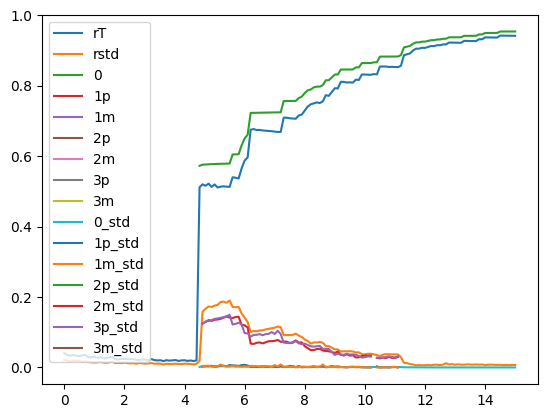

In [1261]:
df_r.plot()

In [1177]:
Ks[45]

4.5

In [1178]:
4.5 * 0.572595

2.5766774999999997

1.267869527886686

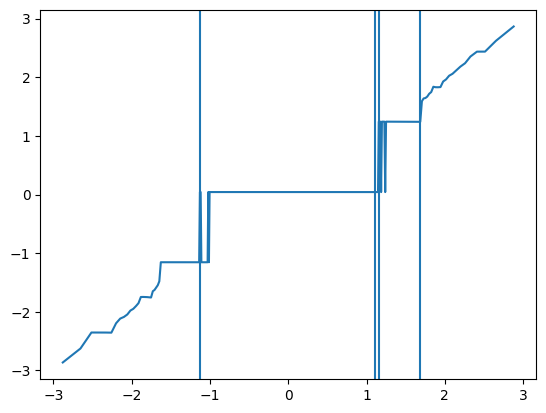

In [1305]:
K_idx = 67
avg_dtheta = (theta_s[K_idx][1000:] - theta_s[K_idx][:-1000])/100
CS,CMP,cluster,_,_,_,_,_,_ =cluster_os_new2(avg_dtheta[-4:-2],height=0.02,check=1,c_size=3,omega=omega)
plt.plot(omega,avg_dtheta[-2])

O_O = np.min(omega[cluster[2]]) - 0.05


O_2O = np.max(omega[cluster[2]])
plt.axvline(O_2O)
plt.axvline(O_O)
plt.axvline(np.min(omega[cluster[2]]))
plt.axvline(np.min(omega[cluster[0]]))

In [1310]:
rr = df_r.loc[Ks[K_idx]]

In [1311]:
rr

rT        0.672454
rstd      0.108129
0         0.723870
1p        0.071513
1m        0.094685
2p             NaN
2m             NaN
3p             NaN
3m             NaN
0_std     0.001978
1p_std    0.002262
1m_std    0.003501
2p_std         NaN
2m_std         NaN
3p_std         NaN
3m_std         NaN
Name: 6.7, dtype: float64

In [1312]:
r0 = rr['rT']
rp = rr['1p']
K = Ks[K_idx]
delta_P = m*K**2*r0*rp/(2*(m**2*O_O**2+1)) - K**2*rp**2/(4*O_O*(4*m**2*O_O**2+1))
print(delta_P)

0.14339585790024034


In [1272]:
O_3O = O_2O - O_O

In [1306]:
# Xs1 = np.logspace(-15,-3,1000)
# Xs = np.r_[Xs1,np.linspace(1e-3,50,2001)]

R_ls = []
R_drs = []

r0 = 0.8
OPS1 = []
for X in Xs:
    omega_p = min(X,O_O)
    OPS1.append(omega_p)
    R_l,err = quad(integrand_Rl, -omega_p,omega_p,args=(X,0,1,m),limit=200)
    R_dr,err = quad(integrand_Rd,omega_p,np.inf,args=(X,0,1,m),limit=200)
    R_ls.append(R_l)
    R_drs.append(R_dr)


R10 = np.array(R_ls)
R1D = 2*np.array(R_drs)
R1 = R10 -R1D
KK1 = 1/(R1/Xs)
K_min_arg = np.argmin(KK)

K_d1 = KK1[:K_min_arg]
K_u1 = KK1[K_min_arg:]
r_d1 = Xs[:K_min_arg]/K_d1
r_u1 = Xs[K_min_arg:]/K_u1
R_01d = R10[:K_min_arg]
R_01u = R10[K_min_arg:]
R_d1d = -R1D[:K_min_arg]
R_d1u = -R1D[K_min_arg:]

R_u1 = R_01u + R_d1u
R_d1 = R_01d + R_d1d

Xsu1 = Xs[K_min_arg:]
Xsd1 = Xs[:K_min_arg]
OPS1 = np.array(OPS1)
OPS1 = OPS1[K_min_arg:]


In [1193]:
df_r.loc[4.6]

KeyError: 4.6

In [1308]:
Ks1,rp1_d,rp1_u,_,_ = get_rp(Xsu1,K_u1,R_01u,OPS1,MAX=False)
Ks1M,rp1M_d,rp1M_u,_,_ = get_rp(Xsu1,K_u1,R_01u,OPS1,MAX=True)

In [1313]:
O_3O =  np.min(omega[cluster[0]]) - np.min(omega[cluster[1]])

In [1314]:
O_3O

0.49912102024384564

In [1315]:
Ks2M,rp2M_d,rp2M_u,_,_ = get_rp2(Xsu1,K_u1,R_01u,OPS1,O_2=O_3O-delta_P)

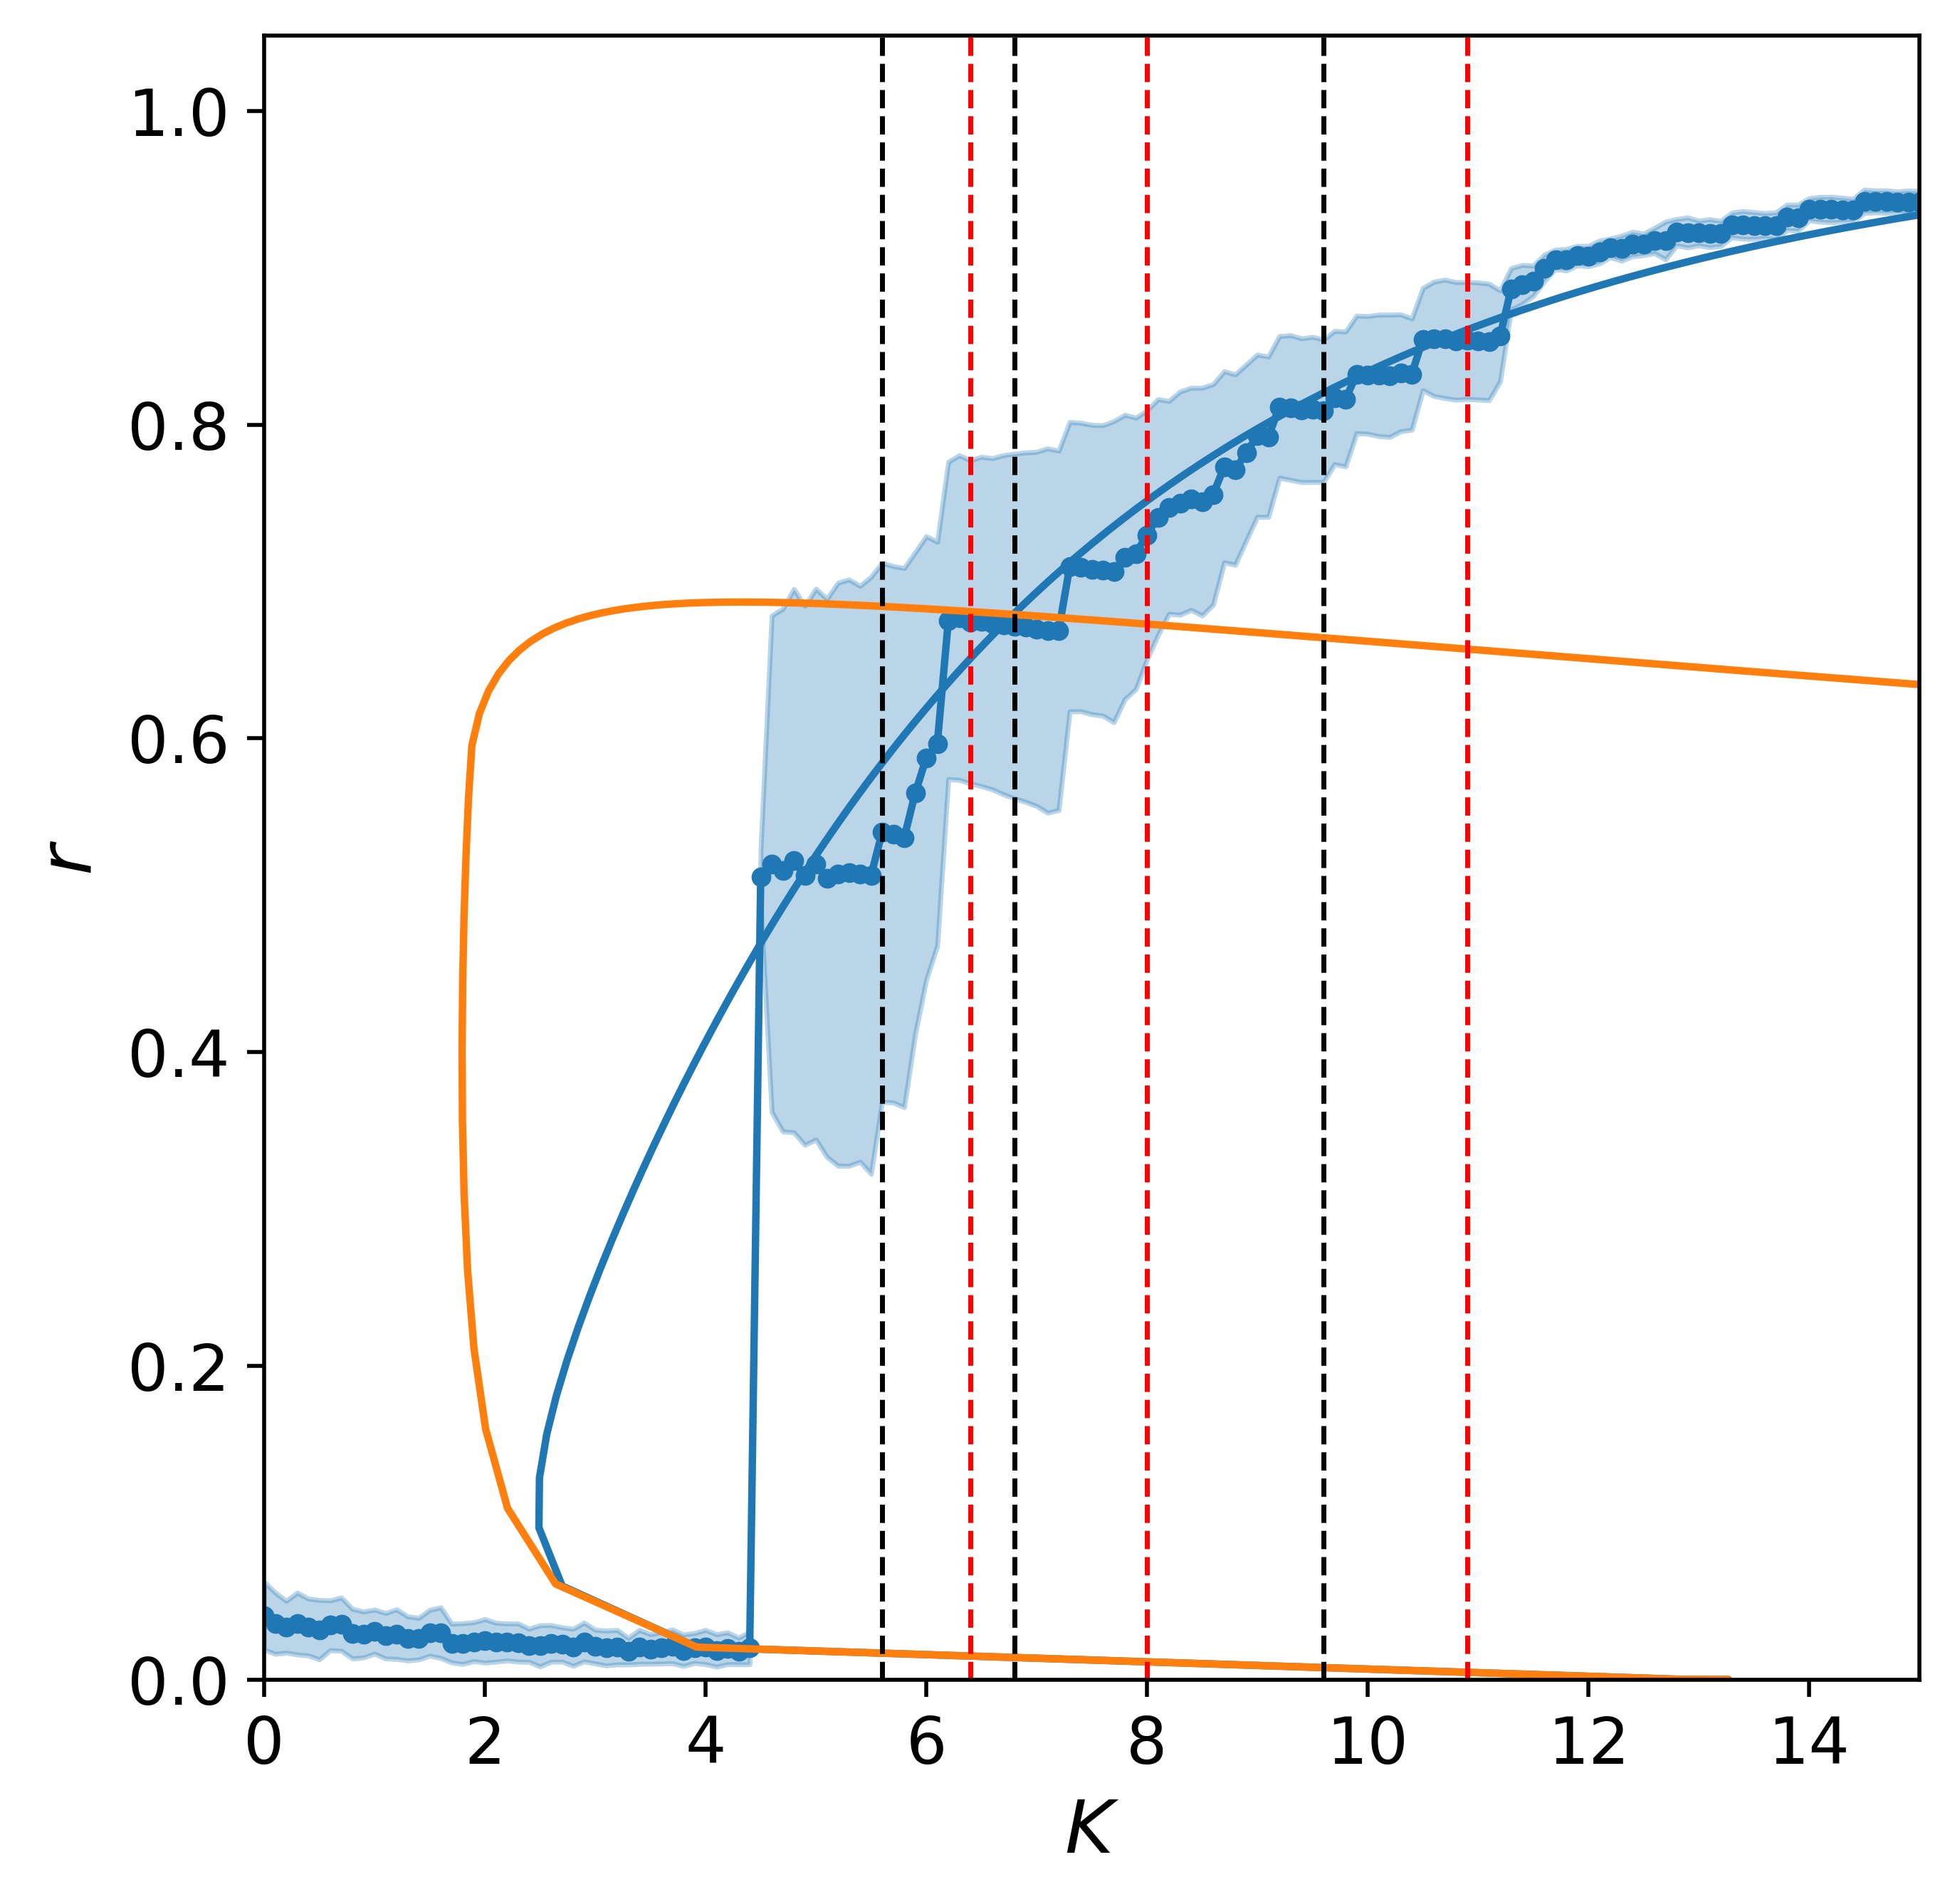

In [1307]:

# DD.plot(style='.-')
# plt.plot(df_rN,'s-')
fig = plt.figure(figsize=(6,6),dpi=500)
# plt.subplot(211)
# plt.plot(K_,F_rN['R0_u'](K_),color='gray',ls='-',lw=3)
# plt.plot(F_rN['Ks'],F_rN['r_+d'],color='gray',ls='-',lw=3)
plt.plot(Ks,df_r['rT'].to_numpy(),'.-',color='tab:blue')
plt.fill_between(Ks,df_r['rT']-df_r['rstd'],df_r['rT']+df_r['rstd'],color='tab:blue',alpha=0.3)

plt.plot(KK,Xs/KK,label='$r$ forward')
plt.plot(KK1,Xs/KK1,label='$r$ forward')

# plt.plot(Ks,df[df.m==6]['r-'],'.-',color='red')
plt.axvline(5.6,lw=1,ls='--',color='black')
plt.axvline(6.4,lw=1,ls='--',color='red')

plt.axvline(6.8,lw=1,ls='--',color='black')
plt.axvline(8.0,lw=1,ls='--',color='red')

plt.axvline(9.6,lw=1,ls='--',color='black')
plt.axvline(10.9,lw=1,ls='--',color='red')

plt.ylim(0,)
plt.xlim(0,15)
# plt.xlabel('$K$',fontsize=15)
plt.ylabel('$r$',fontsize=15)
plt.xlabel('$K$',fontsize=15)

plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
# plt.ylabel('$r_{+},r_{-}$',fontsize=15)
# plt.xticks(fontsize=13)
# plt.yticks(fontsize=13)

plt.show()

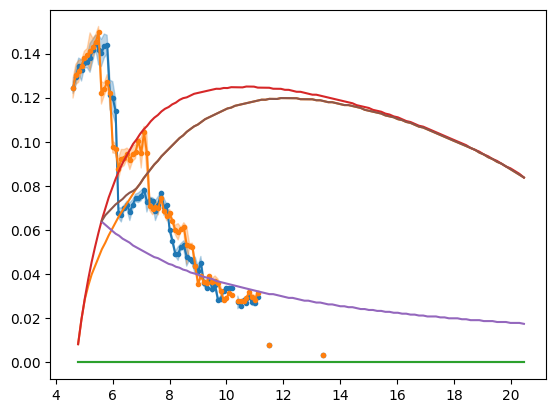

In [1316]:
plt.plot(Ks,df_r['1p'],'.-',color='tab:blue')
plt.fill_between(Ks,df_r['1p']-df_r['1p_std'],df_r['1p']+df_r['1p_std'],color='tab:blue',alpha=0.3)

plt.plot(Ks,df_r['1m'],'.-',color='tab:orange')
plt.fill_between(Ks,df_r['1m']-df_r['1m_std'],df_r['1m']+df_r['1m_std'],color='tab:orange',alpha=0.3)
plt.plot(Ks1,rp1_d)
plt.plot(Ks1,rp1_u)
plt.plot(Ks1M,rp1M_d)
plt.plot(Ks1M,rp1M_u)

plt.plot(Ks2M,rp2M_d)
plt.plot(Ks2M,rp2M_u)